In [3]:
#Basic Computation
import numpy as np
from numpy import arange
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
#Feature Selection Metrics
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
from minepy import MINE
from minepy import cstats

#Preprocessing and performance evaluation
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import log,pi,hypot,fabs,sqrt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# grid search hyperparameters for ridge regression
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
# Model
from sklearn.linear_model import Ridge, Lasso,LinearRegression
from sklearn.linear_model import LogisticRegression,SGDRegressor,TheilSenRegressor
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
import xgboost
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
OUTDATED_IGNORE=1

import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [4]:
def segment(data,col_name):
    Y = (data[col_name])
    X = data.drop(col_name,axis=1)
    return X,Y

In [5]:
def Train_Valid_Test(data,train_percent,valid_percent,test_percent):
    train_len = int(data.shape[0]*train_percent)
    valid_len = int(data.shape[0]*(train_percent + valid_percent)) 
    train_df = data.iloc[:train_len,:]
    valid_df = data.iloc[train_len:valid_len,:]
    test_df = data.iloc[valid_len:,:]
    return train_df,valid_df,test_df

def Split_Part(data,percent):
    train_len = int(data.shape[0]*percent)
    train_df = data.iloc[:train_len,:]
    test_df = data.iloc[train_len:,:]
    return train_df,test_df

In [6]:
def lag_data(data,max_lag,target):
    X = data.copy()
    X_col = list(X.columns)
    X_col.remove(target)
    for col in X_col:
        for i in range(2,max_lag+1):
            X[col+'_lag_'+str(i)] = X[col].shift(i-1)
    for i in X_col:
        X.rename(columns ={i:i+'_lag_1'},inplace = True)
    X.dropna(inplace = True) 
    return X
### Lag the feature based on the order of feature in data.columns
def lag_feature_df(max_lag,data,target):
    # Store each feature's dataframe:
    X = pd.DataFrame()
    X_col = list(data.columns)
    X_col.remove(target)
    feature_range = range(len(X_col))
    for idx,col in enumerate(X_col):
        for j in range(max_lag):
            X[col+'_lag_'+str(j+1)] = data[col].shift(j)
    X[target] = data[target].copy()
    X.dropna(inplace=True)
    return X

In [7]:
air = pd.read_excel(r'./dataset/AirQualityUCI/AirQuality.xlsx',engine='openpyxl',parse_dates=['Date'],index_col = 'Date')
air.drop(columns = air.columns[-2:],axis=1,inplace=True)

df = air.resample('D').sum()
df['C6H6(GT)_1'] = df['C6H6(GT)'].shift(-1)
df.dropna(inplace=True)

In [13]:
x_train_no.shape

(273, 13)

In [14]:
train_no,test_no = Split_Part(df,0.7)
x_train_no,y_train_no = segment(train_no,'C6H6(GT)_1')
x_test_no,y_test_no = segment(test_no,'C6H6(GT)_1')

lag_df = lag_feature_df(30,df,'C6H6(GT)_1')
train_df,test_df = Split_Part(lag_df,0.7)
x_train_L,y_train_L = segment(train_df,'C6H6(GT)_1')
x_test_L,y_test_L = segment(test_df,'C6H6(GT)_1')

train,valid = Split_Part(train_df,0.7)
## Lagging
x_train,y_train = segment(train,'C6H6(GT)_1')
x_valid,y_valid = segment(valid,'C6H6(GT)_1')

In [15]:
X_arr = x_train.values

In [16]:
x_train_no.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

### Construct Corr Matrix 

In [17]:
x_mat = np.zeros([x_train.shape[1],x_train.shape[1]])
feature_num = x_train_no.shape[1]
max_lag = 30

for i in range(0,feature_num):
    ## For each feature,we computew its corr with its self and other features
    ## Self Correlation
    row_start = max_lag*i
    col_end = max_lag*(i+1)
    print(row_start,col_end)
    x_mat[row_start,row_start+1:col_end] = [stats.pearsonr(X_arr[:,row_start],X_arr[:,p])[0] for p in range(max_lag*i+1,max_lag*(i+1))]
    ## Diagnal
    for k in range(row_start+1,col_end-1):
        for j in range(row_start,max_lag*(i+1)-(k-max_lag*i)):
            x_mat[j,j+(k-max_lag*i)] = x_mat[row_start,k]
            
    ## Between Features
    for row in range(col_end,X_arr.shape[1]):
        for col in range(row_start,col_end):
            x_mat[col][row] = stats.pearsonr(X_arr[:,row],X_arr[:,col])[0]

0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360
360 390


In [10]:
corr_copy = x_mat.copy()
corr_copy = np.abs(corr_copy)

In [11]:
def flat(nums):
    res = []
    for i in nums:
        if isinstance(i, list):
            res.extend(flat(i))
        else:
            res.append(i)
    return res

In [14]:
def generate_feature_subsets(corr_matrix,threshold):
    
    correlation_pairs = np.argwhere(corr_matrix>=threshold)
    
    # Check how many features are highly correlated with 1 feature
    correlated_pairs_dict = {}

    for i in set(correlation_pairs[:,0]):
        correlated_pairs_dict[i] = []
        for j in correlation_pairs:
            if j[0]==i:
                correlated_pairs_dict[i].append(j[1])
                
    high_correlated_features = list(set(correlation_pairs.flatten()))
    print("High_correlated_features",len(high_correlated_features))
    corr_cols = x_train.columns[high_correlated_features]
    # Use Mutual Information Regression to rank those highly redundent features
    max_feats = len(corr_cols)
    sel_function = mutual_info_regression
    fs = SelectKBest(score_func=sel_function, k=max_feats)
    fs.fit(x_train[corr_cols],y_train)
    mutual_info = dict(zip(high_correlated_features,fs.scores_))
    sorted_by_mutual_info =[key for (key,val) in sorted(mutual_info.items(), key=lambda kv: kv[1],reverse=True)]
    
    check_corr_pairs = {}
    kk = list(correlated_pairs_dict.keys())
    kk_copy = kk.copy()
    for j in kk_copy:
        check_corr_pairs[j] = correlated_pairs_dict[j].copy()
        for i in correlated_pairs_dict[j]:
            if i in kk:
                check_corr_pairs[j].append(correlated_pairs_dict[i])
                for q in correlated_pairs_dict[i]:
                    if q in kk_copy:
                        kk_copy.remove(q)
            if i in kk_copy:
                    kk_copy.remove(i)
        check_corr_pairs[j] = list(set(flat(check_corr_pairs[j])))
        
    redundant_group = []

    for k,v in check_corr_pairs.items():
        redundant_group.append([k]+v)
    
    mrmr_features = []
    for i in redundant_group:
        indexes = [sorted_by_mutual_info.index(j) for j in i]
        mrmr_features.append(sorted_by_mutual_info[min(indexes)])
    print("MRMR Features",len(mrmr_features))
    
    
    ## Uncorelated features
    lst = []
    for i in range(x_train.shape[1]):
        if i not in high_correlated_features:
            lst.append(i)
    ## Joint filtered features with uncorrelated pairs
    final_list = list(set(mrmr_features+lst))
    
    print("Final Features:",len(final_list))
    return final_list

In [63]:
feature_collections = {}
for i in np.round(arange(0.5,0.99,0.05),3):
    print(i)
    feature_collections[i] = list(x_train.columns[generate_feature_subsets(corr_copy,i)])

0.5
High_correlated_features 390
MRMR Features 49
Final Features: 44
0.55
High_correlated_features 390
MRMR Features 52
Final Features: 45
0.6
High_correlated_features 390
MRMR Features 54
Final Features: 48
0.65
High_correlated_features 390
MRMR Features 56
Final Features: 53
0.7
High_correlated_features 386
MRMR Features 91
Final Features: 89
0.75
High_correlated_features 363
MRMR Features 102
Final Features: 123
0.8
High_correlated_features 330
MRMR Features 70
Final Features: 130
0.85
High_correlated_features 300
MRMR Features 60
Final Features: 150
0.9
High_correlated_features 300
MRMR Features 68
Final Features: 157
0.95
High_correlated_features 162
MRMR Features 51
Final Features: 279


In [64]:
feature_nums = {}
for k,v in feature_collections.items():
    feature_nums[k] = len(v)

### XGBoost
### LightBGM
### RandomForest

### DataSets

Dow Jones Data

Electricity Data

Diamond Data

Air Quality

In [17]:
def lgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    gbm = lgb.LGBMRegressor()
    gbm.fit(x_train, y_train,eval_set = [(x_test,y_test)],early_stopping_rounds = 10)

    features = X_train.columns
    importances = gbm.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = features
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
    
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with LightBGM model')
#     plt.show()
    
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [18]:
def rfr_pipeline(X_train,Y_train,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    
    
    rfr = RandomForestRegressor()
    rfr.fit(x_train,y_train.reshape(-1,))
    
    feature_names = X_train.columns
    importances = rfr.feature_importances_
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
#     plt.title('Top 10 features with Random Forest model')
#     plt.show()
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    
    return top_features

In [19]:
def xgb_pipeline(X_train,Y_train,X_test,Y_test,top_feature_num):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test = minmax_y_test.fit_transform(Y_test.values.reshape(-1,1))
    
    xgb = XGBRegressor()
    xgb.fit(x_train,y_train.reshape(-1,),eval_set=[(x_test, y_test)],early_stopping_rounds=10)

    feature_names = X_train.columns
    importances = xgb.feature_importances_
#     plot_importance(xgb,max_num_features=10,importance_type='gain',show_values=False)
    
    
    importances_df = pd.DataFrame()
    importances_df['Feature_Name'] = feature_names
    importances_df['Feature_Importance'] = importances
    importances_df.sort_values('Feature_Importance', ascending=False,inplace=True)
#     sns.barplot(x=importances_df['Feature_Importance'][:10], y=importances_df['Feature_Name'][:10])
# #     plt.barh(importances_df['Feature_Name'][:10], importances_df['Feature_Importance'][:10]) 
#     plt.title('Top 10 features with XGB model')
#     plt.show()
    top_features = importances_df['Feature_Name'][:top_feature_num].values
    return top_features

In [49]:
def rfr_recursive(cols,feature_num_1,feature_num_2):
    
    max_end = int(0.2*len(cols))
    
    range_end = 0
    
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                rfr_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    rfr_features.append( rfr_pipeline(x_train[now_cols],y_train,j))
                rfr_features = list(set(np.array(rfr_features).flatten()))
                features_dict[j] = rfr_features
                print(j,end='\r',flush=True)
                
            return features_dict
        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
        features_dict = {}
        for j in range(feature_num_1,range_end+1):
            rfr_features = []
            for i in range(5):
                col_len = int(len(cols)*i*0.2)
                now_cols = cols[col_len:]
                rfr_features.append( rfr_pipeline(x_train_L[now_cols],y_train_L,j))

            rfr_features = list(set(np.array(rfr_features).flatten()))
            features_dict[j] = rfr_features
        
            print(j,end='\r',flush=True)
        return features_dict

In [21]:
def lgb_recursive(cols,feature_num_1,feature_num_2):
    
    max_end = int(0.2*len(cols))
    range_end = 0

    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                lgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    lgb_features.append( lgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))

                lgb_features = list(set(np.array(lgb_features).flatten()))
                features_dict[j] = lgb_features
                print(j,end='\r',flush=True)
            return features_dict
        
    features_dict = {}
    
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
    
    for j in range(feature_num_1,range_end+1):
        lgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            lgb_features.append(lgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))
        lgb_features = list(set(np.array(lgb_features).flatten()))
        features_dict[j] = lgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [22]:
def xgb_recursive(cols,feature_num_1,feature_num_2):
    
    max_end = int(0.2*len(cols))
    range_end = 0
    if len(cols)<25:
        
        if len(cols)<=5:
            return cols
        
        if feature_num_1<=max_end:
            features_dict = {}
            for j in range(feature_num_1,max_end+1):
                xgb_features = []
                for i in range(5):
                    col_len = int(len(cols)*i*0.2)
                    now_cols = cols[col_len:]
                    xgb_features.append( xgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))
                xgb_features = list(set(np.array(xgb_features).flatten()))
                features_dict[j] = xgb_features
                print(j,end='\r',flush=True)
            return features_dict
        

        
    if feature_num_2 > max_end:
        renge_end = max_end
    else:
        range_end = feature_num_2
        
    features_dict = {}
    for j in range(feature_num_1,range_end +1):
        xgb_features = []
        for i in range(5):
            col_len = int(len(cols)*i*0.2)
            now_cols = cols[col_len:]
            xgb_features.append( xgb_pipeline(x_train[now_cols],y_train,x_valid[now_cols],y_valid,j))
        xgb_features = list(set(np.array(xgb_features).flatten()))
        features_dict[j] = xgb_features
        print(j,end='\r',flush=True)
    return features_dict

In [65]:
real_lgb = {}
for k,v in feature_collections.items():
    print(k)
    real_lgb[k] = lgb_recursive(v,1,6)

real_xgb = {}
for k,v in feature_collections.items():
    print(k)
    real_xgb[k] = lgb_recursive(v,1,6)

0.5
[1]	valid_0's l2: 0.0240304
[2]	valid_0's l2: 0.0238971
[3]	valid_0's l2: 0.0235874
[4]	valid_0's l2: 0.0233061
[5]	valid_0's l2: 0.0229228
[6]	valid_0's l2: 0.0227944
[7]	valid_0's l2: 0.0226297
[8]	valid_0's l2: 0.0227401
[9]	valid_0's l2: 0.0230409
[10]	valid_0's l2: 0.0231092
[11]	valid_0's l2: 0.0234733
[12]	valid_0's l2: 0.023852
[13]	valid_0's l2: 0.0239666
[14]	valid_0's l2: 0.0240951
[15]	valid_0's l2: 0.024536
[16]	valid_0's l2: 0.0247262
[17]	valid_0's l2: 0.0251924
[1]	valid_0's l2: 0.0240304
[2]	valid_0's l2: 0.0235193
[3]	valid_0's l2: 0.023197
[4]	valid_0's l2: 0.0232726
[5]	valid_0's l2: 0.0228287
[6]	valid_0's l2: 0.0226143
[7]	valid_0's l2: 0.022403
[8]	valid_0's l2: 0.0226311
[9]	valid_0's l2: 0.0227142
[10]	valid_0's l2: 0.0227026
[11]	valid_0's l2: 0.0223795
[12]	valid_0's l2: 0.0227102
[13]	valid_0's l2: 0.0227238
[14]	valid_0's l2: 0.0234416
[15]	valid_0's l2: 0.0234118
[16]	valid_0's l2: 0.0233406
[17]	valid_0's l2: 0.0234812
[18]	valid_0's l2: 0.0241289
[19

[1]	valid_0's l2: 0.0240304
[2]	valid_0's l2: 0.0238971
[3]	valid_0's l2: 0.0235874
[4]	valid_0's l2: 0.0233061
[5]	valid_0's l2: 0.0229228
[6]	valid_0's l2: 0.0227944
[7]	valid_0's l2: 0.0226297
[8]	valid_0's l2: 0.0227401
[9]	valid_0's l2: 0.0230409
[10]	valid_0's l2: 0.0231092
[11]	valid_0's l2: 0.0234733
[12]	valid_0's l2: 0.023852
[13]	valid_0's l2: 0.0239666
[14]	valid_0's l2: 0.0240951
[15]	valid_0's l2: 0.024536
[16]	valid_0's l2: 0.0247262
[17]	valid_0's l2: 0.0251924
[1]	valid_0's l2: 0.0240304
[2]	valid_0's l2: 0.0235193
[3]	valid_0's l2: 0.023197
[4]	valid_0's l2: 0.0232726
[5]	valid_0's l2: 0.0228287
[6]	valid_0's l2: 0.0226143
[7]	valid_0's l2: 0.022403
[8]	valid_0's l2: 0.0226311
[9]	valid_0's l2: 0.0227142
[10]	valid_0's l2: 0.0227026
[11]	valid_0's l2: 0.0223795
[12]	valid_0's l2: 0.0227102
[13]	valid_0's l2: 0.0227238
[14]	valid_0's l2: 0.0234416
[15]	valid_0's l2: 0.0234118
[16]	valid_0's l2: 0.0233406
[17]	valid_0's l2: 0.0234812
[18]	valid_0's l2: 0.0241289
[19]	va

0.55
[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0238994
[3]	valid_0's l2: 0.0235773
[4]	valid_0's l2: 0.02341
[5]	valid_0's l2: 0.023027
[6]	valid_0's l2: 0.0230108
[7]	valid_0's l2: 0.0229836
[8]	valid_0's l2: 0.0233482
[9]	valid_0's l2: 0.0234811
[10]	valid_0's l2: 0.023843
[11]	valid_0's l2: 0.0241013
[12]	valid_0's l2: 0.0242547
[13]	valid_0's l2: 0.0245095
[14]	valid_0's l2: 0.0249889
[15]	valid_0's l2: 0.0252267
[16]	valid_0's l2: 0.0256597
[17]	valid_0's l2: 0.0259321
[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0235217
[3]	valid_0's l2: 0.0232014
[4]	valid_0's l2: 0.0232781
[5]	valid_0's l2: 0.0228317
[6]	valid_0's l2: 0.0227999
[7]	valid_0's l2: 0.0227048
[8]	valid_0's l2: 0.0227153
[9]	valid_0's l2: 0.0226105
[10]	valid_0's l2: 0.0224675
[11]	valid_0's l2: 0.0228557
[12]	valid_0's l2: 0.0225472
[13]	valid_0's l2: 0.0231689
[14]	valid_0's l2: 0.0231641
[15]	valid_0's l2: 0.0233506
[16]	valid_0's l2: 0.0236977
[17]	valid_0's l2: 0.0236683
[18]	valid_0's l2: 0.0241558
[1

[12]	valid_0's l2: 0.0225472
[13]	valid_0's l2: 0.0231689
[14]	valid_0's l2: 0.0231641
[15]	valid_0's l2: 0.0233506
[16]	valid_0's l2: 0.0236977
[17]	valid_0's l2: 0.0236683
[18]	valid_0's l2: 0.0241558
[19]	valid_0's l2: 0.0245316
[20]	valid_0's l2: 0.0249555
[1]	valid_0's l2: 0.0239667
[2]	valid_0's l2: 0.0235869
[3]	valid_0's l2: 0.0235005
[4]	valid_0's l2: 0.0234142
[5]	valid_0's l2: 0.0230975
[6]	valid_0's l2: 0.0231376
[7]	valid_0's l2: 0.0232938
[8]	valid_0's l2: 0.0231127
[9]	valid_0's l2: 0.0229717
[10]	valid_0's l2: 0.0234234
[11]	valid_0's l2: 0.0236556
[12]	valid_0's l2: 0.023277
[13]	valid_0's l2: 0.023436
[14]	valid_0's l2: 0.0233892
[15]	valid_0's l2: 0.0236688
[16]	valid_0's l2: 0.023772
[17]	valid_0's l2: 0.0234895
[18]	valid_0's l2: 0.0238939
[19]	valid_0's l2: 0.0235719
[1]	valid_0's l2: 0.0240015
[2]	valid_0's l2: 0.0237598
[3]	valid_0's l2: 0.0234608
[4]	valid_0's l2: 0.0233694
[5]	valid_0's l2: 0.0234188
[6]	valid_0's l2: 0.0232367
[7]	valid_0's l2: 0.023412
[8]	v

[17]	valid_0's l2: 0.0240348
[18]	valid_0's l2: 0.0237067
[19]	valid_0's l2: 0.0239067
[1]	valid_0's l2: 0.0240015
[2]	valid_0's l2: 0.0237598
[3]	valid_0's l2: 0.0234608
[4]	valid_0's l2: 0.0233694
[5]	valid_0's l2: 0.0234188
[6]	valid_0's l2: 0.0232367
[7]	valid_0's l2: 0.023412
[8]	valid_0's l2: 0.0232985
[9]	valid_0's l2: 0.0235275
[10]	valid_0's l2: 0.0234823
[11]	valid_0's l2: 0.0236725
[12]	valid_0's l2: 0.0235638
[13]	valid_0's l2: 0.0238539
[14]	valid_0's l2: 0.0239701
[15]	valid_0's l2: 0.0239895
[16]	valid_0's l2: 0.0242434
[1]	valid_0's l2: 0.0239481
[2]	valid_0's l2: 0.0235621
[3]	valid_0's l2: 0.0233311
[4]	valid_0's l2: 0.023117
[5]	valid_0's l2: 0.0230075
[6]	valid_0's l2: 0.0228839
[7]	valid_0's l2: 0.0229781
[8]	valid_0's l2: 0.0228588
[9]	valid_0's l2: 0.022862
[10]	valid_0's l2: 0.0228731
[11]	valid_0's l2: 0.0230586
[12]	valid_0's l2: 0.0231077
[13]	valid_0's l2: 0.0231574
[14]	valid_0's l2: 0.0232647
[15]	valid_0's l2: 0.023522
[16]	valid_0's l2: 0.0235409
[17]	va

[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0238994
[3]	valid_0's l2: 0.0235773
[4]	valid_0's l2: 0.02341
[5]	valid_0's l2: 0.023027
[6]	valid_0's l2: 0.0230108
[7]	valid_0's l2: 0.0229836
[8]	valid_0's l2: 0.0233482
[9]	valid_0's l2: 0.0234811
[10]	valid_0's l2: 0.023843
[11]	valid_0's l2: 0.0241013
[12]	valid_0's l2: 0.0242547
[13]	valid_0's l2: 0.0245095
[14]	valid_0's l2: 0.0249889
[15]	valid_0's l2: 0.0252267
[16]	valid_0's l2: 0.0256597
[17]	valid_0's l2: 0.0259321
[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0235217
[3]	valid_0's l2: 0.0232014
[4]	valid_0's l2: 0.0232781
[5]	valid_0's l2: 0.0228317
[6]	valid_0's l2: 0.0227999
[7]	valid_0's l2: 0.0227048
[8]	valid_0's l2: 0.0227153
[9]	valid_0's l2: 0.0226105
[10]	valid_0's l2: 0.0224675
[11]	valid_0's l2: 0.0228557
[12]	valid_0's l2: 0.0225472
[13]	valid_0's l2: 0.0231689
[14]	valid_0's l2: 0.0231661
[15]	valid_0's l2: 0.0233531
[16]	valid_0's l2: 0.023701
[17]	valid_0's l2: 0.0236706
[18]	valid_0's l2: 0.0241582
[19]	val

[2]	valid_0's l2: 0.023758
[3]	valid_0's l2: 0.0234756
[4]	valid_0's l2: 0.0238157
[5]	valid_0's l2: 0.023764
[6]	valid_0's l2: 0.0239657
[7]	valid_0's l2: 0.0240898
[8]	valid_0's l2: 0.0238883
[9]	valid_0's l2: 0.0239946
[10]	valid_0's l2: 0.0238462
[11]	valid_0's l2: 0.0240659
[12]	valid_0's l2: 0.0242134
[13]	valid_0's l2: 0.0241889
[1]	valid_0's l2: 0.0240008
[2]	valid_0's l2: 0.0237597
[3]	valid_0's l2: 0.0234605
[4]	valid_0's l2: 0.0238288
[5]	valid_0's l2: 0.0238197
[6]	valid_0's l2: 0.0240762
[7]	valid_0's l2: 0.0239293
[8]	valid_0's l2: 0.0240825
[9]	valid_0's l2: 0.024333
[10]	valid_0's l2: 0.0242746
[11]	valid_0's l2: 0.0251452
[12]	valid_0's l2: 0.025105
[13]	valid_0's l2: 0.0253895
[1]	valid_0's l2: 0.0239481
[2]	valid_0's l2: 0.0235621
[3]	valid_0's l2: 0.023331
[4]	valid_0's l2: 0.0231179
[5]	valid_0's l2: 0.0230083
[6]	valid_0's l2: 0.0228774
[7]	valid_0's l2: 0.022969
[8]	valid_0's l2: 0.022852
[9]	valid_0's l2: 0.0228557
[10]	valid_0's l2: 0.0228644
[11]	valid_0's l2:

[15]	valid_0's l2: 0.0259591
[16]	valid_0's l2: 0.0266017
[17]	valid_0's l2: 0.0268649
[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0235217
[3]	valid_0's l2: 0.0232638
[4]	valid_0's l2: 0.0233199
[5]	valid_0's l2: 0.0232677
[6]	valid_0's l2: 0.0231517
[7]	valid_0's l2: 0.0231373
[8]	valid_0's l2: 0.0228799
[9]	valid_0's l2: 0.0230213
[10]	valid_0's l2: 0.0233234
[11]	valid_0's l2: 0.0237727
[12]	valid_0's l2: 0.0234535
[13]	valid_0's l2: 0.0237684
[14]	valid_0's l2: 0.0240778
[15]	valid_0's l2: 0.0239923
[16]	valid_0's l2: 0.0242307
[17]	valid_0's l2: 0.0247445
[18]	valid_0's l2: 0.0251801
[1]	valid_0's l2: 0.0239986
[2]	valid_0's l2: 0.023758
[3]	valid_0's l2: 0.0234756
[4]	valid_0's l2: 0.0238157
[5]	valid_0's l2: 0.023764
[6]	valid_0's l2: 0.0239657
[7]	valid_0's l2: 0.0240898
[8]	valid_0's l2: 0.0238883
[9]	valid_0's l2: 0.0239946
[10]	valid_0's l2: 0.0238462
[11]	valid_0's l2: 0.0240659
[12]	valid_0's l2: 0.0242134
[13]	valid_0's l2: 0.0241889
[1]	valid_0's l2: 0.0240008
[2]	va

[12]	valid_0's l2: 0.024198
[13]	valid_0's l2: 0.0244236
[14]	valid_0's l2: 0.0245995
[15]	valid_0's l2: 0.024682
[16]	valid_0's l2: 0.0250054
[1]	valid_0's l2: 0.0247207
[2]	valid_0's l2: 0.0239564
[3]	valid_0's l2: 0.0241097
[4]	valid_0's l2: 0.0236749
[5]	valid_0's l2: 0.0239001
[6]	valid_0's l2: 0.0238049
[7]	valid_0's l2: 0.0238844
[8]	valid_0's l2: 0.0237216
[9]	valid_0's l2: 0.024101
[10]	valid_0's l2: 0.0243008
[11]	valid_0's l2: 0.0246258
[12]	valid_0's l2: 0.0247726
[13]	valid_0's l2: 0.0250341
[14]	valid_0's l2: 0.0253341
[1]	valid_0's l2: 0.0245962
[2]	valid_0's l2: 0.0238429
[3]	valid_0's l2: 0.0239917
[4]	valid_0's l2: 0.0235782
[5]	valid_0's l2: 0.0238067
[6]	valid_0's l2: 0.0237284
[7]	valid_0's l2: 0.0239814
[8]	valid_0's l2: 0.0239061
[9]	valid_0's l2: 0.0245679
[10]	valid_0's l2: 0.0248506
[11]	valid_0's l2: 0.0249245
[12]	valid_0's l2: 0.0253045
[13]	valid_0's l2: 0.0256061
[14]	valid_0's l2: 0.0260029
[1]	valid_0's l2: 0.0237175
[2]	valid_0's l2: 0.0234142
[3]	vali

[24]	valid_0's l2: 0.0201461
[25]	valid_0's l2: 0.0200247
[26]	valid_0's l2: 0.0197103
[27]	valid_0's l2: 0.019601
[28]	valid_0's l2: 0.0199735
[29]	valid_0's l2: 0.0196035
[30]	valid_0's l2: 0.0195492
[31]	valid_0's l2: 0.0196759
[32]	valid_0's l2: 0.0192925
[33]	valid_0's l2: 0.0196315
[34]	valid_0's l2: 0.0195362
[35]	valid_0's l2: 0.0195039
[36]	valid_0's l2: 0.0197914
[37]	valid_0's l2: 0.0198259
[38]	valid_0's l2: 0.0198199
[39]	valid_0's l2: 0.019809
[40]	valid_0's l2: 0.020043
[41]	valid_0's l2: 0.0201083
[42]	valid_0's l2: 0.020155
[1]	valid_0's l2: 0.0238503
[2]	valid_0's l2: 0.0233195
[3]	valid_0's l2: 0.0227489
[4]	valid_0's l2: 0.0219502
[5]	valid_0's l2: 0.021536
[6]	valid_0's l2: 0.0209899
[7]	valid_0's l2: 0.0207269
[8]	valid_0's l2: 0.0203617
[9]	valid_0's l2: 0.0201661
[10]	valid_0's l2: 0.0199365
[11]	valid_0's l2: 0.0197103
[12]	valid_0's l2: 0.01954
[13]	valid_0's l2: 0.0191933
[14]	valid_0's l2: 0.0190258
[15]	valid_0's l2: 0.0193234
[16]	valid_0's l2: 0.0193462
[

[11]	valid_0's l2: 0.0223297
[12]	valid_0's l2: 0.0219491
[13]	valid_0's l2: 0.0215753
[14]	valid_0's l2: 0.0214692
[15]	valid_0's l2: 0.0218659
[16]	valid_0's l2: 0.021564
[17]	valid_0's l2: 0.0214272
[18]	valid_0's l2: 0.0211039
[19]	valid_0's l2: 0.0214431
[20]	valid_0's l2: 0.0216351
[21]	valid_0's l2: 0.0216654
[22]	valid_0's l2: 0.0216536
[23]	valid_0's l2: 0.021989
[24]	valid_0's l2: 0.0218684
[25]	valid_0's l2: 0.0219586
[26]	valid_0's l2: 0.0217853
[27]	valid_0's l2: 0.0219072
[28]	valid_0's l2: 0.0218419
[1]	valid_0's l2: 0.0238969
[2]	valid_0's l2: 0.0233778
[3]	valid_0's l2: 0.0228602
[4]	valid_0's l2: 0.0220954
[5]	valid_0's l2: 0.0223015
[6]	valid_0's l2: 0.0218772
[7]	valid_0's l2: 0.0214273
[8]	valid_0's l2: 0.0218221
[9]	valid_0's l2: 0.0214097
[10]	valid_0's l2: 0.0209815
[11]	valid_0's l2: 0.0211878
[12]	valid_0's l2: 0.0210591
[13]	valid_0's l2: 0.0208324
[14]	valid_0's l2: 0.0206496
[15]	valid_0's l2: 0.0207315
[16]	valid_0's l2: 0.02048
[17]	valid_0's l2: 0.020384

[29]	valid_0's l2: 0.0184109
[30]	valid_0's l2: 0.0184023
[31]	valid_0's l2: 0.018273
[32]	valid_0's l2: 0.0185201
[33]	valid_0's l2: 0.0185688
[34]	valid_0's l2: 0.0185504
[35]	valid_0's l2: 0.0188446
[1]	valid_0's l2: 0.0238291
[2]	valid_0's l2: 0.0231732
[3]	valid_0's l2: 0.0226183
[4]	valid_0's l2: 0.0222302
[5]	valid_0's l2: 0.0217786
[6]	valid_0's l2: 0.0214684
[7]	valid_0's l2: 0.0211279
[8]	valid_0's l2: 0.0207576
[9]	valid_0's l2: 0.0204213
[10]	valid_0's l2: 0.0201597
[11]	valid_0's l2: 0.0198409
[12]	valid_0's l2: 0.0195998
[13]	valid_0's l2: 0.0194645
[14]	valid_0's l2: 0.0192294
[15]	valid_0's l2: 0.0189961
[16]	valid_0's l2: 0.018907
[17]	valid_0's l2: 0.0187921
[18]	valid_0's l2: 0.0186062
[19]	valid_0's l2: 0.0185231
[20]	valid_0's l2: 0.0188288
[21]	valid_0's l2: 0.0186652
[22]	valid_0's l2: 0.018537
[23]	valid_0's l2: 0.0185402
[24]	valid_0's l2: 0.018478
[25]	valid_0's l2: 0.0181859
[26]	valid_0's l2: 0.0180874
[27]	valid_0's l2: 0.0181745
[28]	valid_0's l2: 0.018452

[29]	valid_0's l2: 0.0199648
[30]	valid_0's l2: 0.0200395
[1]	valid_0's l2: 0.0238969
[2]	valid_0's l2: 0.0233778
[3]	valid_0's l2: 0.0228838
[4]	valid_0's l2: 0.02213
[5]	valid_0's l2: 0.0223337
[6]	valid_0's l2: 0.0219093
[7]	valid_0's l2: 0.0214827
[8]	valid_0's l2: 0.021882
[9]	valid_0's l2: 0.0214676
[10]	valid_0's l2: 0.0210355
[11]	valid_0's l2: 0.0212474
[12]	valid_0's l2: 0.0209947
[13]	valid_0's l2: 0.0208547
[14]	valid_0's l2: 0.0212033
[15]	valid_0's l2: 0.0208947
[16]	valid_0's l2: 0.0205901
[17]	valid_0's l2: 0.0205008
[18]	valid_0's l2: 0.0205488
[19]	valid_0's l2: 0.0201942
[20]	valid_0's l2: 0.0198575
[21]	valid_0's l2: 0.0199138
[22]	valid_0's l2: 0.0198576
[23]	valid_0's l2: 0.0198336
[24]	valid_0's l2: 0.0201461
[25]	valid_0's l2: 0.0200247
[26]	valid_0's l2: 0.0197103
[27]	valid_0's l2: 0.019601
[28]	valid_0's l2: 0.0199735
[29]	valid_0's l2: 0.0196035
[30]	valid_0's l2: 0.0195492
[31]	valid_0's l2: 0.0196759
[32]	valid_0's l2: 0.0192925
[33]	valid_0's l2: 0.019631

[14]	valid_0's l2: 0.0253984
[1]	valid_0's l2: 0.0245828
[2]	valid_0's l2: 0.0246395
[3]	valid_0's l2: 0.0243793
[4]	valid_0's l2: 0.0240358
[5]	valid_0's l2: 0.0237414
[6]	valid_0's l2: 0.0237897
[7]	valid_0's l2: 0.0236225
[8]	valid_0's l2: 0.0235824
[9]	valid_0's l2: 0.0239639
[10]	valid_0's l2: 0.0239645
[11]	valid_0's l2: 0.0237778
[12]	valid_0's l2: 0.0241138
[13]	valid_0's l2: 0.0238718
[14]	valid_0's l2: 0.0236791
[15]	valid_0's l2: 0.0237293
[16]	valid_0's l2: 0.0237206
[17]	valid_0's l2: 0.0237554
[18]	valid_0's l2: 0.0235074
[19]	valid_0's l2: 0.0233486
[20]	valid_0's l2: 0.0234082
[21]	valid_0's l2: 0.0232633
[22]	valid_0's l2: 0.0232885
[23]	valid_0's l2: 0.02328
[24]	valid_0's l2: 0.0232041
[25]	valid_0's l2: 0.023175
[26]	valid_0's l2: 0.0229587
[27]	valid_0's l2: 0.022845
[28]	valid_0's l2: 0.0227118
[29]	valid_0's l2: 0.0229021
[30]	valid_0's l2: 0.0229253
[31]	valid_0's l2: 0.0228927
[32]	valid_0's l2: 0.0227509
[33]	valid_0's l2: 0.0226497
[34]	valid_0's l2: 0.022855

[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0246205
[3]	valid_0's l2: 0.0239686
[4]	valid_0's l2: 0.0236337
[5]	valid_0's l2: 0.0237695
[6]	valid_0's l2: 0.0236805
[7]	valid_0's l2: 0.024066
[8]	valid_0's l2: 0.0238991
[9]	valid_0's l2: 0.0236705
[10]	valid_0's l2: 0.0239722
[11]	valid_0's l2: 0.0237096
[12]	valid_0's l2: 0.0236568
[13]	valid_0's l2: 0.0240441
[14]	valid_0's l2: 0.0244408
[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0242343
[3]	valid_0's l2: 0.0235487
[4]	valid_0's l2: 0.0237949
[5]	valid_0's l2: 0.0234264
[6]	valid_0's l2: 0.0231821
[7]	valid_0's l2: 0.023144
[8]	valid_0's l2: 0.0233959
[9]	valid_0's l2: 0.023318
[10]	valid_0's l2: 0.0232321
[11]	valid_0's l2: 0.0232203
[12]	valid_0's l2: 0.0230999
[13]	valid_0's l2: 0.0233776
[14]	valid_0's l2: 0.0231276
[15]	valid_0's l2: 0.0232543
[16]	valid_0's l2: 0.0236464
[17]	valid_0's l2: 0.0237387
[18]	valid_0's l2: 0.0236428
[19]	valid_0's l2: 0.0241891
[20]	valid_0's l2: 0.024445
[21]	valid_0's l2: 0.0247053
[22]	va

[12]	valid_0's l2: 0.0234357
[13]	valid_0's l2: 0.0231905
[14]	valid_0's l2: 0.0230549
[15]	valid_0's l2: 0.0231181
[16]	valid_0's l2: 0.023175
[17]	valid_0's l2: 0.0233052
[18]	valid_0's l2: 0.0231898
[19]	valid_0's l2: 0.0232385
[20]	valid_0's l2: 0.0232006
[21]	valid_0's l2: 0.0234573
[22]	valid_0's l2: 0.0233112
[23]	valid_0's l2: 0.0233307
[24]	valid_0's l2: 0.0231406
[1]	valid_0's l2: 0.0239682
[2]	valid_0's l2: 0.0235883
[3]	valid_0's l2: 0.0234594
[4]	valid_0's l2: 0.0237309
[5]	valid_0's l2: 0.0236282
[6]	valid_0's l2: 0.0234299
[7]	valid_0's l2: 0.0235404
[8]	valid_0's l2: 0.023506
[9]	valid_0's l2: 0.0235637
[10]	valid_0's l2: 0.0243287
[11]	valid_0's l2: 0.0242293
[12]	valid_0's l2: 0.0248917
[13]	valid_0's l2: 0.024914
[14]	valid_0's l2: 0.0249555
[15]	valid_0's l2: 0.0254867
[16]	valid_0's l2: 0.0254578
[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0246205
[3]	valid_0's l2: 0.0239686
[4]	valid_0's l2: 0.0236337
[5]	valid_0's l2: 0.0237695
[6]	valid_0's l2: 0.0236805
[7]

[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0246205
[3]	valid_0's l2: 0.0239686
[4]	valid_0's l2: 0.0236337
[5]	valid_0's l2: 0.0237695
[6]	valid_0's l2: 0.0236805
[7]	valid_0's l2: 0.024066
[8]	valid_0's l2: 0.0238991
[9]	valid_0's l2: 0.0236705
[10]	valid_0's l2: 0.0239722
[11]	valid_0's l2: 0.0237096
[12]	valid_0's l2: 0.0236568
[13]	valid_0's l2: 0.0240441
[14]	valid_0's l2: 0.0244408
[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0242343
[3]	valid_0's l2: 0.0235487
[4]	valid_0's l2: 0.0237949
[5]	valid_0's l2: 0.0234264
[6]	valid_0's l2: 0.0231685
[7]	valid_0's l2: 0.0231267
[8]	valid_0's l2: 0.023378
[9]	valid_0's l2: 0.0232983
[10]	valid_0's l2: 0.0232111
[11]	valid_0's l2: 0.0231975
[12]	valid_0's l2: 0.0230768
[13]	valid_0's l2: 0.0233545
[14]	valid_0's l2: 0.0231036
[15]	valid_0's l2: 0.0232283
[16]	valid_0's l2: 0.0236225
[17]	valid_0's l2: 0.0236935
[18]	valid_0's l2: 0.0235674
[19]	valid_0's l2: 0.0238003
[20]	valid_0's l2: 0.024061
[21]	valid_0's l2: 0.0244971
[22]	v

[53]	valid_0's l2: 0.0211267
[54]	valid_0's l2: 0.0210629
[55]	valid_0's l2: 0.021093
[56]	valid_0's l2: 0.021187
[57]	valid_0's l2: 0.0211629
[58]	valid_0's l2: 0.0211934
[59]	valid_0's l2: 0.0211856
[60]	valid_0's l2: 0.0212192
[61]	valid_0's l2: 0.0213447
[62]	valid_0's l2: 0.0212883
[63]	valid_0's l2: 0.021275
[64]	valid_0's l2: 0.0212968
[1]	valid_0's l2: 0.0239682
[2]	valid_0's l2: 0.0235883
[3]	valid_0's l2: 0.0234594
[4]	valid_0's l2: 0.0237309
[5]	valid_0's l2: 0.0236282
[6]	valid_0's l2: 0.0234299
[7]	valid_0's l2: 0.0235404
[8]	valid_0's l2: 0.0234408
[9]	valid_0's l2: 0.0234686
[10]	valid_0's l2: 0.0236631
[11]	valid_0's l2: 0.0236317
[12]	valid_0's l2: 0.0236838
[13]	valid_0's l2: 0.0242194
[14]	valid_0's l2: 0.0241894
[15]	valid_0's l2: 0.0244049
[16]	valid_0's l2: 0.0253356
[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0246205
[3]	valid_0's l2: 0.0239686
[4]	valid_0's l2: 0.0236337
[5]	valid_0's l2: 0.0237693
[6]	valid_0's l2: 0.0236812
[7]	valid_0's l2: 0.0240128
[8]	

[1]	valid_0's l2: 0.0239682
[2]	valid_0's l2: 0.0235883
[3]	valid_0's l2: 0.0234594
[4]	valid_0's l2: 0.0237309
[5]	valid_0's l2: 0.0236282
[6]	valid_0's l2: 0.0234299
[7]	valid_0's l2: 0.0235404
[8]	valid_0's l2: 0.0234408
[9]	valid_0's l2: 0.0234686
[10]	valid_0's l2: 0.0236631
[11]	valid_0's l2: 0.0236317
[12]	valid_0's l2: 0.0236838
[13]	valid_0's l2: 0.0242194
[14]	valid_0's l2: 0.0241894
[15]	valid_0's l2: 0.0244049
[16]	valid_0's l2: 0.0253356
[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0246205
[3]	valid_0's l2: 0.0239686
[4]	valid_0's l2: 0.0236337
[5]	valid_0's l2: 0.0237693
[6]	valid_0's l2: 0.0236812
[7]	valid_0's l2: 0.0240128
[8]	valid_0's l2: 0.0238489
[9]	valid_0's l2: 0.0236161
[10]	valid_0's l2: 0.0239152
[11]	valid_0's l2: 0.0237036
[12]	valid_0's l2: 0.0236542
[13]	valid_0's l2: 0.0239188
[14]	valid_0's l2: 0.0242394
[15]	valid_0's l2: 0.0239733
[16]	valid_0's l2: 0.0239137
[17]	valid_0's l2: 0.0243138
[18]	valid_0's l2: 0.0243129
[19]	valid_0's l2: 0.0243849
[1]

[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0246205
[3]	valid_0's l2: 0.0239686
[4]	valid_0's l2: 0.0236337
[5]	valid_0's l2: 0.0237693
[6]	valid_0's l2: 0.0236812
[7]	valid_0's l2: 0.0240128
[8]	valid_0's l2: 0.0238489
[9]	valid_0's l2: 0.0236161
[10]	valid_0's l2: 0.0239152
[11]	valid_0's l2: 0.0237036
[12]	valid_0's l2: 0.0236542
[13]	valid_0's l2: 0.0239188
[14]	valid_0's l2: 0.0242394
[15]	valid_0's l2: 0.0239733
[16]	valid_0's l2: 0.0239137
[17]	valid_0's l2: 0.0243138
[18]	valid_0's l2: 0.0243129
[19]	valid_0's l2: 0.0243849
[1]	valid_0's l2: 0.0247207
[2]	valid_0's l2: 0.0239639
[3]	valid_0's l2: 0.0241011
[4]	valid_0's l2: 0.0236918
[5]	valid_0's l2: 0.0239127
[6]	valid_0's l2: 0.023811
[7]	valid_0's l2: 0.0239909
[8]	valid_0's l2: 0.0239014
[9]	valid_0's l2: 0.0232335
[10]	valid_0's l2: 0.0236054
[11]	valid_0's l2: 0.0236351
[12]	valid_0's l2: 0.0240255
[13]	valid_0's l2: 0.023983
[14]	valid_0's l2: 0.0239643
[15]	valid_0's l2: 0.0241357
[16]	valid_0's l2: 0.0243928
[17]	

[1]	valid_0's l2: 0.0238425
[2]	valid_0's l2: 0.0234628
[3]	valid_0's l2: 0.0233047
[4]	valid_0's l2: 0.0233113
[5]	valid_0's l2: 0.0234449
[6]	valid_0's l2: 0.0236855
[7]	valid_0's l2: 0.0238636
[8]	valid_0's l2: 0.023488
[9]	valid_0's l2: 0.0236543
[10]	valid_0's l2: 0.0238089
[11]	valid_0's l2: 0.0239327
[12]	valid_0's l2: 0.0241035
[13]	valid_0's l2: 0.0243422
[1]	valid_0's l2: 0.0238325
[2]	valid_0's l2: 0.0234072
[3]	valid_0's l2: 0.0232418
[4]	valid_0's l2: 0.0232479
[5]	valid_0's l2: 0.0232981
[6]	valid_0's l2: 0.0234642
[7]	valid_0's l2: 0.0236452
[8]	valid_0's l2: 0.0232703
[9]	valid_0's l2: 0.0233957
[10]	valid_0's l2: 0.0236446
[11]	valid_0's l2: 0.0239166
[12]	valid_0's l2: 0.0234462
[13]	valid_0's l2: 0.0232527
[1]	valid_0's l2: 0.024319
[2]	valid_0's l2: 0.024679
[3]	valid_0's l2: 0.0239498
[4]	valid_0's l2: 0.0241739
[5]	valid_0's l2: 0.0237476
[6]	valid_0's l2: 0.0233407
[7]	valid_0's l2: 0.0236164
[8]	valid_0's l2: 0.0236058
[9]	valid_0's l2: 0.0240343
[10]	valid_0's 

0.5
[1]	valid_0's l2: 0.0240304
[2]	valid_0's l2: 0.0238971
[3]	valid_0's l2: 0.0235874
[4]	valid_0's l2: 0.0233061
[5]	valid_0's l2: 0.0229228
[6]	valid_0's l2: 0.0227944
[7]	valid_0's l2: 0.0226297
[8]	valid_0's l2: 0.0227401
[9]	valid_0's l2: 0.0230409
[10]	valid_0's l2: 0.0231092
[11]	valid_0's l2: 0.0234733
[12]	valid_0's l2: 0.023852
[13]	valid_0's l2: 0.0239666
[14]	valid_0's l2: 0.0240951
[15]	valid_0's l2: 0.024536
[16]	valid_0's l2: 0.0247262
[17]	valid_0's l2: 0.0251924
[1]	valid_0's l2: 0.0240304
[2]	valid_0's l2: 0.0235193
[3]	valid_0's l2: 0.023197
[4]	valid_0's l2: 0.0232726
[5]	valid_0's l2: 0.0228287
[6]	valid_0's l2: 0.0226143
[7]	valid_0's l2: 0.022403
[8]	valid_0's l2: 0.0226311
[9]	valid_0's l2: 0.0227142
[10]	valid_0's l2: 0.0227026
[11]	valid_0's l2: 0.0223795
[12]	valid_0's l2: 0.0227102
[13]	valid_0's l2: 0.0227238
[14]	valid_0's l2: 0.0234416
[15]	valid_0's l2: 0.0234118
[16]	valid_0's l2: 0.0233406
[17]	valid_0's l2: 0.0234812
[18]	valid_0's l2: 0.0241289
[19

[1]	valid_0's l2: 0.0240304
[2]	valid_0's l2: 0.0238971
[3]	valid_0's l2: 0.0235874
[4]	valid_0's l2: 0.0233061
[5]	valid_0's l2: 0.0229228
[6]	valid_0's l2: 0.0227944
[7]	valid_0's l2: 0.0226297
[8]	valid_0's l2: 0.0227401
[9]	valid_0's l2: 0.0230409
[10]	valid_0's l2: 0.0231092
[11]	valid_0's l2: 0.0234733
[12]	valid_0's l2: 0.023852
[13]	valid_0's l2: 0.0239666
[14]	valid_0's l2: 0.0240951
[15]	valid_0's l2: 0.024536
[16]	valid_0's l2: 0.0247262
[17]	valid_0's l2: 0.0251924
[1]	valid_0's l2: 0.0240304
[2]	valid_0's l2: 0.0235193
[3]	valid_0's l2: 0.023197
[4]	valid_0's l2: 0.0232726
[5]	valid_0's l2: 0.0228287
[6]	valid_0's l2: 0.0226143
[7]	valid_0's l2: 0.022403
[8]	valid_0's l2: 0.0226311
[9]	valid_0's l2: 0.0227142
[10]	valid_0's l2: 0.0227026
[11]	valid_0's l2: 0.0223795
[12]	valid_0's l2: 0.0227102
[13]	valid_0's l2: 0.0227238
[14]	valid_0's l2: 0.0234416
[15]	valid_0's l2: 0.0234118
[16]	valid_0's l2: 0.0233406
[17]	valid_0's l2: 0.0234812
[18]	valid_0's l2: 0.0241289
[19]	va

0.55
[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0238994
[3]	valid_0's l2: 0.0235773
[4]	valid_0's l2: 0.02341
[5]	valid_0's l2: 0.023027
[6]	valid_0's l2: 0.0230108
[7]	valid_0's l2: 0.0229836
[8]	valid_0's l2: 0.0233482
[9]	valid_0's l2: 0.0234811
[10]	valid_0's l2: 0.023843
[11]	valid_0's l2: 0.0241013
[12]	valid_0's l2: 0.0242547
[13]	valid_0's l2: 0.0245095
[14]	valid_0's l2: 0.0249889
[15]	valid_0's l2: 0.0252267
[16]	valid_0's l2: 0.0256597
[17]	valid_0's l2: 0.0259321
[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0235217
[3]	valid_0's l2: 0.0232014
[4]	valid_0's l2: 0.0232781
[5]	valid_0's l2: 0.0228317
[6]	valid_0's l2: 0.0227999
[7]	valid_0's l2: 0.0227048
[8]	valid_0's l2: 0.0227153
[9]	valid_0's l2: 0.0226105
[10]	valid_0's l2: 0.0224675
[11]	valid_0's l2: 0.0228557
[12]	valid_0's l2: 0.0225472
[13]	valid_0's l2: 0.0231689
[14]	valid_0's l2: 0.0231641
[15]	valid_0's l2: 0.0233506
[16]	valid_0's l2: 0.0236977
[17]	valid_0's l2: 0.0236683
[18]	valid_0's l2: 0.0241558
[1

[6]	valid_0's l2: 0.0231376
[7]	valid_0's l2: 0.0232938
[8]	valid_0's l2: 0.0231127
[9]	valid_0's l2: 0.0229717
[10]	valid_0's l2: 0.0234234
[11]	valid_0's l2: 0.0236556
[12]	valid_0's l2: 0.023277
[13]	valid_0's l2: 0.023436
[14]	valid_0's l2: 0.0233892
[15]	valid_0's l2: 0.0236688
[16]	valid_0's l2: 0.023772
[17]	valid_0's l2: 0.0234895
[18]	valid_0's l2: 0.0238939
[19]	valid_0's l2: 0.0235719
[1]	valid_0's l2: 0.0240015
[2]	valid_0's l2: 0.0237598
[3]	valid_0's l2: 0.0234608
[4]	valid_0's l2: 0.0233694
[5]	valid_0's l2: 0.0234188
[6]	valid_0's l2: 0.0232367
[7]	valid_0's l2: 0.023412
[8]	valid_0's l2: 0.0232985
[9]	valid_0's l2: 0.0235275
[10]	valid_0's l2: 0.0234823
[11]	valid_0's l2: 0.0236725
[12]	valid_0's l2: 0.0235638
[13]	valid_0's l2: 0.0238539
[14]	valid_0's l2: 0.0239701
[15]	valid_0's l2: 0.0239895
[16]	valid_0's l2: 0.0242434
[1]	valid_0's l2: 0.0245871
[2]	valid_0's l2: 0.0241613
[3]	valid_0's l2: 0.0238944
[4]	valid_0's l2: 0.0236998
[5]	valid_0's l2: 0.0235088
[6]	val

[15]	valid_0's l2: 0.0239895
[16]	valid_0's l2: 0.0242434
[1]	valid_0's l2: 0.0239481
[2]	valid_0's l2: 0.0235621
[3]	valid_0's l2: 0.0233311
[4]	valid_0's l2: 0.023117
[5]	valid_0's l2: 0.0230075
[6]	valid_0's l2: 0.0228839
[7]	valid_0's l2: 0.0229781
[8]	valid_0's l2: 0.0228588
[9]	valid_0's l2: 0.022862
[10]	valid_0's l2: 0.0228731
[11]	valid_0's l2: 0.0230586
[12]	valid_0's l2: 0.0231077
[13]	valid_0's l2: 0.0231574
[14]	valid_0's l2: 0.0232647
[15]	valid_0's l2: 0.023522
[16]	valid_0's l2: 0.0235409
[17]	valid_0's l2: 0.0237941
[18]	valid_0's l2: 0.0242423
[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0238994
[3]	valid_0's l2: 0.0235773
[4]	valid_0's l2: 0.02341
[5]	valid_0's l2: 0.023027
[6]	valid_0's l2: 0.0230108
[7]	valid_0's l2: 0.0229836
[8]	valid_0's l2: 0.0233482
[9]	valid_0's l2: 0.0234811
[10]	valid_0's l2: 0.023843
[11]	valid_0's l2: 0.0241013
[12]	valid_0's l2: 0.0242547
[13]	valid_0's l2: 0.0245095
[14]	valid_0's l2: 0.0249889
[15]	valid_0's l2: 0.0252267
[16]	valid

[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0238994
[3]	valid_0's l2: 0.0235773
[4]	valid_0's l2: 0.02341
[5]	valid_0's l2: 0.023027
[6]	valid_0's l2: 0.0230108
[7]	valid_0's l2: 0.0229836
[8]	valid_0's l2: 0.0233482
[9]	valid_0's l2: 0.0234811
[10]	valid_0's l2: 0.023843
[11]	valid_0's l2: 0.0241013
[12]	valid_0's l2: 0.0242547
[13]	valid_0's l2: 0.0245095
[14]	valid_0's l2: 0.0249889
[15]	valid_0's l2: 0.0252267
[16]	valid_0's l2: 0.0256597
[17]	valid_0's l2: 0.0259321
[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0235217
[3]	valid_0's l2: 0.0232014
[4]	valid_0's l2: 0.0232781
[5]	valid_0's l2: 0.0228317
[6]	valid_0's l2: 0.0227999
[7]	valid_0's l2: 0.0227048
[8]	valid_0's l2: 0.0227153
[9]	valid_0's l2: 0.0226105
[10]	valid_0's l2: 0.0224675
[11]	valid_0's l2: 0.0228557
[12]	valid_0's l2: 0.0225472
[13]	valid_0's l2: 0.0231689
[14]	valid_0's l2: 0.0231661
[15]	valid_0's l2: 0.0233531
[16]	valid_0's l2: 0.023701
[17]	valid_0's l2: 0.0236706
[18]	valid_0's l2: 0.0241582
[19]	val

[1]	valid_0's l2: 0.0240008
[2]	valid_0's l2: 0.0237597
[3]	valid_0's l2: 0.0234605
[4]	valid_0's l2: 0.0238288
[5]	valid_0's l2: 0.0238197
[6]	valid_0's l2: 0.0240762
[7]	valid_0's l2: 0.0239293
[8]	valid_0's l2: 0.0240825
[9]	valid_0's l2: 0.024333
[10]	valid_0's l2: 0.0242746
[11]	valid_0's l2: 0.0251452
[12]	valid_0's l2: 0.025105
[13]	valid_0's l2: 0.0253895
[1]	valid_0's l2: 0.0239481
[2]	valid_0's l2: 0.0235621
[3]	valid_0's l2: 0.023331
[4]	valid_0's l2: 0.0231179
[5]	valid_0's l2: 0.0230083
[6]	valid_0's l2: 0.0228774
[7]	valid_0's l2: 0.022969
[8]	valid_0's l2: 0.022852
[9]	valid_0's l2: 0.0228557
[10]	valid_0's l2: 0.0228644
[11]	valid_0's l2: 0.023049
[12]	valid_0's l2: 0.0230985
[13]	valid_0's l2: 0.0231463
[14]	valid_0's l2: 0.0232533
[15]	valid_0's l2: 0.0235097
[16]	valid_0's l2: 0.0235296
[17]	valid_0's l2: 0.0239743
[18]	valid_0's l2: 0.0242318
[1]	valid_0's l2: 0.0240294
[2]	valid_0's l2: 0.0238994
[3]	valid_0's l2: 0.0236277
[4]	valid_0's l2: 0.0234993
[5]	valid_0's

[2]	valid_0's l2: 0.023758
[3]	valid_0's l2: 0.0234756
[4]	valid_0's l2: 0.0238157
[5]	valid_0's l2: 0.023764
[6]	valid_0's l2: 0.0239657
[7]	valid_0's l2: 0.0240898
[8]	valid_0's l2: 0.0238883
[9]	valid_0's l2: 0.0239946
[10]	valid_0's l2: 0.0238462
[11]	valid_0's l2: 0.0240659
[12]	valid_0's l2: 0.0242134
[13]	valid_0's l2: 0.0241889
[1]	valid_0's l2: 0.0240008
[2]	valid_0's l2: 0.0237597
[3]	valid_0's l2: 0.0234605
[4]	valid_0's l2: 0.0238288
[5]	valid_0's l2: 0.0238197
[6]	valid_0's l2: 0.0240762
[7]	valid_0's l2: 0.0239293
[8]	valid_0's l2: 0.0240825
[9]	valid_0's l2: 0.024333
[10]	valid_0's l2: 0.0242746
[11]	valid_0's l2: 0.0251452
[12]	valid_0's l2: 0.025105
[13]	valid_0's l2: 0.0253895
[1]	valid_0's l2: 0.0239481
[2]	valid_0's l2: 0.0235621
[3]	valid_0's l2: 0.023331
[4]	valid_0's l2: 0.0231179
[5]	valid_0's l2: 0.0230083
[6]	valid_0's l2: 0.0228774
[7]	valid_0's l2: 0.022969
[8]	valid_0's l2: 0.022852
[9]	valid_0's l2: 0.0228557
[10]	valid_0's l2: 0.0228644
[11]	valid_0's l2:

[1]	valid_0's l2: 0.0245962
[2]	valid_0's l2: 0.0238429
[3]	valid_0's l2: 0.0239917
[4]	valid_0's l2: 0.0235782
[5]	valid_0's l2: 0.0238067
[6]	valid_0's l2: 0.0237284
[7]	valid_0's l2: 0.0239814
[8]	valid_0's l2: 0.0239061
[9]	valid_0's l2: 0.0245679
[10]	valid_0's l2: 0.0248506
[11]	valid_0's l2: 0.0249245
[12]	valid_0's l2: 0.0253045
[13]	valid_0's l2: 0.0256061
[14]	valid_0's l2: 0.0260029
[1]	valid_0's l2: 0.0237175
[2]	valid_0's l2: 0.0234142
[3]	valid_0's l2: 0.0235944
[4]	valid_0's l2: 0.0231582
[5]	valid_0's l2: 0.0233156
[6]	valid_0's l2: 0.0231167
[7]	valid_0's l2: 0.0232707
[8]	valid_0's l2: 0.0236576
[9]	valid_0's l2: 0.023406
[10]	valid_0's l2: 0.0233675
[11]	valid_0's l2: 0.0237419
[12]	valid_0's l2: 0.0239036
[13]	valid_0's l2: 0.024301
[14]	valid_0's l2: 0.0246766
[15]	valid_0's l2: 0.0248431
[16]	valid_0's l2: 0.0253896
[1]	valid_0's l2: 0.0243471
[2]	valid_0's l2: 0.0243136
[3]	valid_0's l2: 0.0243528
[4]	valid_0's l2: 0.0241615
[5]	valid_0's l2: 0.0242114
[6]	valid_

[2]	valid_0's l2: 0.0233195
[3]	valid_0's l2: 0.0227489
[4]	valid_0's l2: 0.0219502
[5]	valid_0's l2: 0.021536
[6]	valid_0's l2: 0.0209899
[7]	valid_0's l2: 0.0207269
[8]	valid_0's l2: 0.0203617
[9]	valid_0's l2: 0.0201661
[10]	valid_0's l2: 0.0199365
[11]	valid_0's l2: 0.0197103
[12]	valid_0's l2: 0.01954
[13]	valid_0's l2: 0.0191933
[14]	valid_0's l2: 0.0190258
[15]	valid_0's l2: 0.0193234
[16]	valid_0's l2: 0.0193462
[17]	valid_0's l2: 0.019054
[18]	valid_0's l2: 0.0189314
[19]	valid_0's l2: 0.0187907
[20]	valid_0's l2: 0.018932
[21]	valid_0's l2: 0.0189093
[22]	valid_0's l2: 0.0186906
[23]	valid_0's l2: 0.0184128
[24]	valid_0's l2: 0.0182802
[25]	valid_0's l2: 0.0182098
[26]	valid_0's l2: 0.018493
[27]	valid_0's l2: 0.0184179
[28]	valid_0's l2: 0.01851
[29]	valid_0's l2: 0.0184109
[30]	valid_0's l2: 0.0184023
[31]	valid_0's l2: 0.018273
[32]	valid_0's l2: 0.0185201
[33]	valid_0's l2: 0.0185688
[34]	valid_0's l2: 0.0185504
[35]	valid_0's l2: 0.0188446
[1]	valid_0's l2: 0.0238291
[2]

[1]	valid_0's l2: 0.0238969
[2]	valid_0's l2: 0.0233778
[3]	valid_0's l2: 0.0228602
[4]	valid_0's l2: 0.0220954
[5]	valid_0's l2: 0.0223015
[6]	valid_0's l2: 0.0218772
[7]	valid_0's l2: 0.0214273
[8]	valid_0's l2: 0.0218221
[9]	valid_0's l2: 0.0214097
[10]	valid_0's l2: 0.0209815
[11]	valid_0's l2: 0.0211878
[12]	valid_0's l2: 0.0210591
[13]	valid_0's l2: 0.0208324
[14]	valid_0's l2: 0.0206496
[15]	valid_0's l2: 0.0207315
[16]	valid_0's l2: 0.02048
[17]	valid_0's l2: 0.0203843
[18]	valid_0's l2: 0.0204518
[19]	valid_0's l2: 0.0200131
[20]	valid_0's l2: 0.0197408
[21]	valid_0's l2: 0.0199355
[22]	valid_0's l2: 0.0199014
[23]	valid_0's l2: 0.0202294
[24]	valid_0's l2: 0.02016
[25]	valid_0's l2: 0.0198882
[26]	valid_0's l2: 0.0198159
[27]	valid_0's l2: 0.0197761
[28]	valid_0's l2: 0.0198324
[29]	valid_0's l2: 0.0199648
[30]	valid_0's l2: 0.0200395
[1]	valid_0's l2: 0.0238969
[2]	valid_0's l2: 0.0233778
[3]	valid_0's l2: 0.0228838
[4]	valid_0's l2: 0.02213
[5]	valid_0's l2: 0.0223337
[6]	v

[2]	valid_0's l2: 0.0231732
[3]	valid_0's l2: 0.0226183
[4]	valid_0's l2: 0.0222302
[5]	valid_0's l2: 0.0217786
[6]	valid_0's l2: 0.0214684
[7]	valid_0's l2: 0.0211279
[8]	valid_0's l2: 0.0207576
[9]	valid_0's l2: 0.0204213
[10]	valid_0's l2: 0.0201597
[11]	valid_0's l2: 0.0198409
[12]	valid_0's l2: 0.0195998
[13]	valid_0's l2: 0.0194645
[14]	valid_0's l2: 0.0192294
[15]	valid_0's l2: 0.0189961
[16]	valid_0's l2: 0.018907
[17]	valid_0's l2: 0.0187921
[18]	valid_0's l2: 0.0186062
[19]	valid_0's l2: 0.0185231
[20]	valid_0's l2: 0.0188288
[21]	valid_0's l2: 0.0186652
[22]	valid_0's l2: 0.018537
[23]	valid_0's l2: 0.0185402
[24]	valid_0's l2: 0.018478
[25]	valid_0's l2: 0.0181859
[26]	valid_0's l2: 0.0180874
[27]	valid_0's l2: 0.0181745
[28]	valid_0's l2: 0.0184529
[29]	valid_0's l2: 0.0180963
[30]	valid_0's l2: 0.0179452
[31]	valid_0's l2: 0.0178409
[32]	valid_0's l2: 0.0177115
[33]	valid_0's l2: 0.0180072
[34]	valid_0's l2: 0.017776
[35]	valid_0's l2: 0.0176653
[36]	valid_0's l2: 0.01785

[1]	valid_0's l2: 0.0238503
[2]	valid_0's l2: 0.0233195
[3]	valid_0's l2: 0.0227489
[4]	valid_0's l2: 0.0219502
[5]	valid_0's l2: 0.021536
[6]	valid_0's l2: 0.0209899
[7]	valid_0's l2: 0.0207269
[8]	valid_0's l2: 0.0203617
[9]	valid_0's l2: 0.0201661
[10]	valid_0's l2: 0.0199365
[11]	valid_0's l2: 0.0197103
[12]	valid_0's l2: 0.01954
[13]	valid_0's l2: 0.0191933
[14]	valid_0's l2: 0.0190258
[15]	valid_0's l2: 0.0193234
[16]	valid_0's l2: 0.0193462
[17]	valid_0's l2: 0.019054
[18]	valid_0's l2: 0.0189314
[19]	valid_0's l2: 0.0187907
[20]	valid_0's l2: 0.018932
[21]	valid_0's l2: 0.0189093
[22]	valid_0's l2: 0.0186906
[23]	valid_0's l2: 0.0184128
[24]	valid_0's l2: 0.0182802
[25]	valid_0's l2: 0.0182098
[26]	valid_0's l2: 0.018493
[27]	valid_0's l2: 0.0184179
[28]	valid_0's l2: 0.01851
[29]	valid_0's l2: 0.0184109
[30]	valid_0's l2: 0.0184023
[31]	valid_0's l2: 0.018273
[32]	valid_0's l2: 0.0185201
[33]	valid_0's l2: 0.0185688
[34]	valid_0's l2: 0.0185504
[35]	valid_0's l2: 0.0188446
[1]

[3]	valid_0's l2: 0.0234594
[4]	valid_0's l2: 0.0237309
[5]	valid_0's l2: 0.0236282
[6]	valid_0's l2: 0.0234299
[7]	valid_0's l2: 0.0235404
[8]	valid_0's l2: 0.023506
[9]	valid_0's l2: 0.0235637
[10]	valid_0's l2: 0.0243287
[11]	valid_0's l2: 0.0242293
[12]	valid_0's l2: 0.0248917
[13]	valid_0's l2: 0.0249131
[14]	valid_0's l2: 0.024958
[15]	valid_0's l2: 0.0255147
[16]	valid_0's l2: 0.0254846
[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0246205
[3]	valid_0's l2: 0.0239686
[4]	valid_0's l2: 0.0236337
[5]	valid_0's l2: 0.0237695
[6]	valid_0's l2: 0.0236805
[7]	valid_0's l2: 0.024066
[8]	valid_0's l2: 0.0238991
[9]	valid_0's l2: 0.0236705
[10]	valid_0's l2: 0.0239722
[11]	valid_0's l2: 0.0237096
[12]	valid_0's l2: 0.0236568
[13]	valid_0's l2: 0.0240441
[14]	valid_0's l2: 0.0244408
[1]	valid_0's l2: 0.0243319
[2]	valid_0's l2: 0.0242343
[3]	valid_0's l2: 0.0235487
[4]	valid_0's l2: 0.0237949
[5]	valid_0's l2: 0.0234264
[6]	valid_0's l2: 0.0231821
[7]	valid_0's l2: 0.023144
[8]	valid_0'

[2]	valid_0's l2: 0.0246395
[3]	valid_0's l2: 0.0243793
[4]	valid_0's l2: 0.0240358
[5]	valid_0's l2: 0.0237414
[6]	valid_0's l2: 0.0237897
[7]	valid_0's l2: 0.0236225
[8]	valid_0's l2: 0.0235824
[9]	valid_0's l2: 0.0239639
[10]	valid_0's l2: 0.0239645
[11]	valid_0's l2: 0.0237778
[12]	valid_0's l2: 0.0241138
[13]	valid_0's l2: 0.0238718
[14]	valid_0's l2: 0.0236791
[15]	valid_0's l2: 0.0237293
[16]	valid_0's l2: 0.0237206
[17]	valid_0's l2: 0.0237554
[18]	valid_0's l2: 0.0235074
[19]	valid_0's l2: 0.0233486
[20]	valid_0's l2: 0.0234082
[21]	valid_0's l2: 0.0232633
[22]	valid_0's l2: 0.0232885
[23]	valid_0's l2: 0.02328
[24]	valid_0's l2: 0.0232041
[25]	valid_0's l2: 0.023175
[26]	valid_0's l2: 0.0229587
[27]	valid_0's l2: 0.022845
[28]	valid_0's l2: 0.0227118
[29]	valid_0's l2: 0.0229021
[30]	valid_0's l2: 0.0229253
[31]	valid_0's l2: 0.0228927
[32]	valid_0's l2: 0.0227509
[33]	valid_0's l2: 0.0226497
[34]	valid_0's l2: 0.0228557
[35]	valid_0's l2: 0.0228443
[36]	valid_0's l2: 0.02289

[8]	valid_0's l2: 0.023378
[9]	valid_0's l2: 0.0232983
[10]	valid_0's l2: 0.0232111
[11]	valid_0's l2: 0.0231975
[12]	valid_0's l2: 0.0230768
[13]	valid_0's l2: 0.0233545
[14]	valid_0's l2: 0.0231036
[15]	valid_0's l2: 0.0232283
[16]	valid_0's l2: 0.0236225
[17]	valid_0's l2: 0.0236935
[18]	valid_0's l2: 0.0235674
[19]	valid_0's l2: 0.0238003
[20]	valid_0's l2: 0.024061
[21]	valid_0's l2: 0.0244971
[22]	valid_0's l2: 0.0246304
[1]	valid_0's l2: 0.0247311
[2]	valid_0's l2: 0.0239768
[3]	valid_0's l2: 0.0241109
[4]	valid_0's l2: 0.0237001
[5]	valid_0's l2: 0.0239232
[6]	valid_0's l2: 0.0238316
[7]	valid_0's l2: 0.0240813
[8]	valid_0's l2: 0.0239967
[9]	valid_0's l2: 0.0243635
[10]	valid_0's l2: 0.0242766
[11]	valid_0's l2: 0.0241786
[12]	valid_0's l2: 0.024602
[13]	valid_0's l2: 0.0246897
[14]	valid_0's l2: 0.0250765
[1]	valid_0's l2: 0.0245828
[2]	valid_0's l2: 0.0246395
[3]	valid_0's l2: 0.0243793
[4]	valid_0's l2: 0.0240358
[5]	valid_0's l2: 0.0237415
[6]	valid_0's l2: 0.0237944
[7]	v

[1]	valid_0's l2: 0.0245828
[2]	valid_0's l2: 0.0246395
[3]	valid_0's l2: 0.0243793
[4]	valid_0's l2: 0.0240358
[5]	valid_0's l2: 0.0237415
[6]	valid_0's l2: 0.0237944
[7]	valid_0's l2: 0.0236272
[8]	valid_0's l2: 0.0233346
[9]	valid_0's l2: 0.0237121
[10]	valid_0's l2: 0.0237678
[11]	valid_0's l2: 0.0234186
[12]	valid_0's l2: 0.0234357
[13]	valid_0's l2: 0.0231905
[14]	valid_0's l2: 0.0230549
[15]	valid_0's l2: 0.0231181
[16]	valid_0's l2: 0.023175
[17]	valid_0's l2: 0.0233052
[18]	valid_0's l2: 0.0231898
[19]	valid_0's l2: 0.0232385
[20]	valid_0's l2: 0.0232006
[21]	valid_0's l2: 0.0234573
[22]	valid_0's l2: 0.0233112
[23]	valid_0's l2: 0.0233307
[24]	valid_0's l2: 0.0231406
[1]	valid_0's l2: 0.0239682
[2]	valid_0's l2: 0.0235883
[3]	valid_0's l2: 0.0234594
[4]	valid_0's l2: 0.0237309
[5]	valid_0's l2: 0.0236282
[6]	valid_0's l2: 0.0234299
[7]	valid_0's l2: 0.0235404
[8]	valid_0's l2: 0.023506
[9]	valid_0's l2: 0.0235637
[10]	valid_0's l2: 0.0243287
[11]	valid_0's l2: 0.0242293
[12]	

[2]	valid_0's l2: 0.023976
[3]	valid_0's l2: 0.0241106
[4]	valid_0's l2: 0.0237001
[5]	valid_0's l2: 0.0239226
[6]	valid_0's l2: 0.0238306
[7]	valid_0's l2: 0.0240797
[8]	valid_0's l2: 0.0239954
[9]	valid_0's l2: 0.0239687
[10]	valid_0's l2: 0.0233041
[11]	valid_0's l2: 0.0236475
[12]	valid_0's l2: 0.0237023
[13]	valid_0's l2: 0.0240604
[14]	valid_0's l2: 0.0240258
[15]	valid_0's l2: 0.0241969
[16]	valid_0's l2: 0.0242173
[17]	valid_0's l2: 0.0244982
[18]	valid_0's l2: 0.0248777
[19]	valid_0's l2: 0.0252492
[20]	valid_0's l2: 0.0248321
[1]	valid_0's l2: 0.0245828
[2]	valid_0's l2: 0.0246395
[3]	valid_0's l2: 0.024028
[4]	valid_0's l2: 0.0236998
[5]	valid_0's l2: 0.0235994
[6]	valid_0's l2: 0.0233261
[7]	valid_0's l2: 0.0231502
[8]	valid_0's l2: 0.0232974
[9]	valid_0's l2: 0.023238
[10]	valid_0's l2: 0.0232731
[11]	valid_0's l2: 0.0231435
[12]	valid_0's l2: 0.0232229
[13]	valid_0's l2: 0.0232712
[14]	valid_0's l2: 0.0231162
[15]	valid_0's l2: 0.0230116
[16]	valid_0's l2: 0.023002
[17]	v

[31]	valid_0's l2: 0.0219004
[32]	valid_0's l2: 0.0219241
[33]	valid_0's l2: 0.0218068
[34]	valid_0's l2: 0.0218629
[35]	valid_0's l2: 0.0217667
[36]	valid_0's l2: 0.0217099
[37]	valid_0's l2: 0.0215552
[38]	valid_0's l2: 0.0218404
[39]	valid_0's l2: 0.0217323
[40]	valid_0's l2: 0.0219501
[41]	valid_0's l2: 0.0218453
[42]	valid_0's l2: 0.0216668
[43]	valid_0's l2: 0.0216966
[44]	valid_0's l2: 0.0215284
[45]	valid_0's l2: 0.0216447
[46]	valid_0's l2: 0.0215319
[47]	valid_0's l2: 0.0214159
[48]	valid_0's l2: 0.0213462
[49]	valid_0's l2: 0.0211943
[50]	valid_0's l2: 0.0212489
[51]	valid_0's l2: 0.0211747
[52]	valid_0's l2: 0.0212158
[53]	valid_0's l2: 0.0211267
[54]	valid_0's l2: 0.0210629
[55]	valid_0's l2: 0.021093
[56]	valid_0's l2: 0.021187
[57]	valid_0's l2: 0.0211629
[58]	valid_0's l2: 0.0211934
[59]	valid_0's l2: 0.0211856
[60]	valid_0's l2: 0.0212192
[61]	valid_0's l2: 0.0213447
[62]	valid_0's l2: 0.0212883
[63]	valid_0's l2: 0.021275
[64]	valid_0's l2: 0.0212968
[1]	valid_0's l2:

[1]	valid_0's l2: 0.0239682
[2]	valid_0's l2: 0.0235883
[3]	valid_0's l2: 0.0234594
[4]	valid_0's l2: 0.0237309
[5]	valid_0's l2: 0.0236282
[6]	valid_0's l2: 0.0234299
[7]	valid_0's l2: 0.0235404
[8]	valid_0's l2: 0.0234408
[9]	valid_0's l2: 0.0234686
[10]	valid_0's l2: 0.0236631
[11]	valid_0's l2: 0.0236317
[12]	valid_0's l2: 0.0236838
[13]	valid_0's l2: 0.0242194
[14]	valid_0's l2: 0.0241894
[15]	valid_0's l2: 0.0244049
[16]	valid_0's l2: 0.0253356
0.95
[1]	valid_0's l2: 0.0238425
[2]	valid_0's l2: 0.0234628
[3]	valid_0's l2: 0.0233047
[4]	valid_0's l2: 0.0233113
[5]	valid_0's l2: 0.0234449
[6]	valid_0's l2: 0.0236855
[7]	valid_0's l2: 0.0238636
[8]	valid_0's l2: 0.023488
[9]	valid_0's l2: 0.0236543
[10]	valid_0's l2: 0.0238089
[11]	valid_0's l2: 0.0239327
[12]	valid_0's l2: 0.0241035
[13]	valid_0's l2: 0.0243422
[1]	valid_0's l2: 0.0238325
[2]	valid_0's l2: 0.0234072
[3]	valid_0's l2: 0.0232418
[4]	valid_0's l2: 0.0232479
[5]	valid_0's l2: 0.0232981
[6]	valid_0's l2: 0.0234642
[7]	v

[2]	valid_0's l2: 0.0240005
[3]	valid_0's l2: 0.0243124
[4]	valid_0's l2: 0.0238256
[5]	valid_0's l2: 0.0237156
[6]	valid_0's l2: 0.0238851
[7]	valid_0's l2: 0.0238655
[8]	valid_0's l2: 0.0241194
[9]	valid_0's l2: 0.0241277
[10]	valid_0's l2: 0.0240092
[11]	valid_0's l2: 0.024195
[12]	valid_0's l2: 0.0242502
[13]	valid_0's l2: 0.0241834
[14]	valid_0's l2: 0.0247944
[15]	valid_0's l2: 0.0247771
[1]	valid_0's l2: 0.0238425
[2]	valid_0's l2: 0.0234628
[3]	valid_0's l2: 0.0233047
[4]	valid_0's l2: 0.0233113
[5]	valid_0's l2: 0.0234449
[6]	valid_0's l2: 0.0236855
[7]	valid_0's l2: 0.0238636
[8]	valid_0's l2: 0.023488
[9]	valid_0's l2: 0.0236543
[10]	valid_0's l2: 0.0238089
[11]	valid_0's l2: 0.0239327
[12]	valid_0's l2: 0.0241035
[13]	valid_0's l2: 0.0243422
[1]	valid_0's l2: 0.0238325
[2]	valid_0's l2: 0.0234072
[3]	valid_0's l2: 0.0232418
[4]	valid_0's l2: 0.0232479
[5]	valid_0's l2: 0.0232981
[6]	valid_0's l2: 0.0234642
[7]	valid_0's l2: 0.0236452
[8]	valid_0's l2: 0.0232703
[9]	valid_0'

In [79]:
real_rfr = {}
for k,v in feature_collections.items():
    print(k)
    real_rfr[k] = rfr_recursive(v,1,6)

0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


### Mix Models

In [25]:
import random

In [26]:
def mix_recursive(final_cols,feature_num):
    mix_features = []
    for i in range(5):
        col_len = int(len(final_cols)*i*0.2)
        now_cols = final_cols[col_len:]
        rm = random.randint(1,3)
        if rm==1:
            model = xgb_pipeline
        elif rm==2:
            model = rf_pipeline
        else:
            model = lgb_pipeline
        mix_features.append(model(x_train_L[now_cols],y_train_L,feature_num))
    mix_features = np.array(mix_features)
    real_mix = set(mix_features.flatten())
    real_mix = list(real_mix)
    return real_mix

In [64]:
mix_features = mix_recursive(final_cols,1)

In [65]:
len(mix_features)

2

In [66]:
Linear_Regressor(x_train_L[mix_features],y_train_L,x_test_L[mix_features],y_test_L)

rmse:  9.405188317514515 mae: 8.346582248013874


,Actual,Linear Regression Predict
0,9278.53,9273.718015
1,9277.43,9270.222580
2,9277.67,9269.133351
3,9272.28,9269.371001
4,9274.87,9263.693504
...,...,...
327,10368.67,10362.900452
328,10376.10,10366.191547
329,10378.43,10373.548795
330,10385.16,10376.536527


## Prediction Models

In [27]:
def rfr_regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))

    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    rfr = RandomForestRegressor()
    
    rfr.fit(x_train,y_train.reshape(-1,))
    y_rfr = rfr.predict(x_test)
    y_rfr_inverse =minmax_y_test.inverse_transform(y_rfr.reshape((-1,1)))
    
    print(
          "RandomForest_mae:%f"%(mean_absolute_error(y_rfr_inverse, Y_test  ))+"\n",
          "RandomForest_rmse:%f"%(sqrt(mean_squared_error(y_rfr_inverse, Y_test  )))+"\n"
#           "elastic_mse:%f"%(mean_squared_error( y_elastic_inverse, Y_test  )),     
     )
    
    y_df = {
        "Original": Y_test.values,
        'RandomForest_':y_rfr_inverse
    }
    
    error_metrics = {
        "mae":(mean_absolute_error(y_rfr_inverse, Y_test  )),
        "rmse":(sqrt(mean_squared_error(y_rfr_inverse, Y_test  )))
    }
    return error_metrics

In [80]:
rfr_regressor(x_train,y_train,x_test_L,y_test_L)

RandomForest_mae:468.320903
 RandomForest_rmse:1031.009108



{'mae': 468.320903421466, 'rmse': 1031.0091080509508}

In [85]:
rfr_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    rfr_lgb_error[k] = []
    if type(v)==list:
        rfr_lgb_error[k].append(rfr_regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        avg_rfr_lgb.append(rfr_lgb_error[k])
        rfr_lgb_error[k] = pd.DataFrame(rfr_lgb_error[k])
        
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            rfr_lgb_error[k].append(rfr_regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        rfr_lgb_error[k] = pd.DataFrame(rfr_lgb_error[k],index = list(v.keys()))

rfr_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    rfr_xgb_error[k] = []
    if type(v)==list:
        rfr_xgb_error[k].append(rfr_regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        rfr_xgb_error[k] = pd.DataFrame(rfr_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            rfr_xgb_error[k].append(rfr_regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        rfr_xgb_error[k] = pd.DataFrame(rfr_xgb_error[k],index = list(v.keys()))
    
rfr_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    rfr_rfr_error[k] = []
    if type(v) == list:
        rfr_rfr_error[k].append(rfr_regressor(x_train_L[v],y_train_L,x_test_L[v],y_test_L))
        rfr_rfr_error[k] = pd.DataFrame(rfr_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            rfr_rfr_error[k].append(rfr_regressor(x_train_L[vv],y_train_L,x_test_L[vv],y_test_L))
        rfr_rfr_error[k] = pd.DataFrame(rfr_rfr_error[k],index = list(v.keys()))

0.5
1 1
RandomForest_mae:527.703912
 RandomForest_rmse:1249.203380

2 5
RandomForest_mae:776.571374
 RandomForest_rmse:1441.190267

3 8
RandomForest_mae:776.116988
 RandomForest_rmse:1378.950517

4 10
RandomForest_mae:665.926777
 RandomForest_rmse:1102.387916

5 13
RandomForest_mae:553.861948
 RandomForest_rmse:965.319755

6 16
RandomForest_mae:658.207770
 RandomForest_rmse:1028.730611

0.55
1 1
RandomForest_mae:535.355887
 RandomForest_rmse:1247.627811

2 5
RandomForest_mae:500.669213
 RandomForest_rmse:1056.473758

3 6
RandomForest_mae:596.921622
 RandomForest_rmse:1081.309588

4 9
RandomForest_mae:607.283939
 RandomForest_rmse:1110.089338

5 11
RandomForest_mae:565.043923
 RandomForest_rmse:1048.365475

6 13
RandomForest_mae:598.830766
 RandomForest_rmse:1080.590788

0.6
1 1
RandomForest_mae:532.202785
 RandomForest_rmse:1253.284732

2 5
RandomForest_mae:508.074959
 RandomForest_rmse:1101.170928

3 6
RandomForest_mae:580.482675
 RandomForest_rmse:1091.990574

4 9
RandomForest_mae:56

RandomForest_mae:587.375895
 RandomForest_rmse:1124.225301

3 8
RandomForest_mae:607.538172
 RandomForest_rmse:1113.170661

4 10
RandomForest_mae:599.130190
 RandomForest_rmse:1152.986709

5 13
RandomForest_mae:696.453774
 RandomForest_rmse:1247.553655

6 15
RandomForest_mae:665.798141
 RandomForest_rmse:1226.215178

0.6
1 3
RandomForest_mae:433.046170
 RandomForest_rmse:1054.527449

2 6
RandomForest_mae:528.828092
 RandomForest_rmse:1088.849061

3 8
RandomForest_mae:597.300856
 RandomForest_rmse:1116.320607

4 8
RandomForest_mae:563.299883
 RandomForest_rmse:1069.121485

5 11
RandomForest_mae:664.156280
 RandomForest_rmse:1176.269759

6 14
RandomForest_mae:645.917479
 RandomForest_rmse:1200.259296

0.65
1 3
RandomForest_mae:498.821978
 RandomForest_rmse:1028.226965

2 5
RandomForest_mae:595.806552
 RandomForest_rmse:1179.238362

3 8
RandomForest_mae:630.248002
 RandomForest_rmse:1150.490683

4 8
RandomForest_mae:604.581472
 RandomForest_rmse:1090.934209

5 12
RandomForest_mae:625.0459

In [86]:
def avg_rmse(error_list):
    avg = []
    flat = list(error_list.values())
    for i in flat:
        for j in i['rmse'].values:
            avg.append(j)
    avg_score = np.round(mean(avg),3)
    return avg_score

In [87]:
avg_rfr_lgb = avg_rmse(rfr_lgb_error)
avg_rfr_xgb = avg_rmse(rfr_xgb_error)
avg_rfr_rfr = avg_rmse(rfr_rfr_error)

In [88]:
avg_rfr_lgb,avg_rfr_xgb,avg_rfr_rfr

(1062.688, 1060.678, 1117.854)

In [18]:
def join_err(err):
    error_dict = copy.deepcopy(err)
    for k,v in error_dict.items():
        pd.MultiIndex.from_product([[k],v.columns])
        v.columns = pd.MultiIndex.from_product([ [k],v.columns ])
    err_df = pd.concat([error_dict[k] for k in error_dict.keys()],axis=1)
    print("Min",np.min(err_df.loc[:,pd.IndexSlice[:,'rmse']].values))
    return err_df

In [19]:
rfr_lgb = join_err(rfr_lgb_error)
rfr_xgb = join_err(rfr_xgb_error)
rfr_rfr = join_err(rfr_rfr_error)

NameError: name 'rfr_lgb_error' is not defined

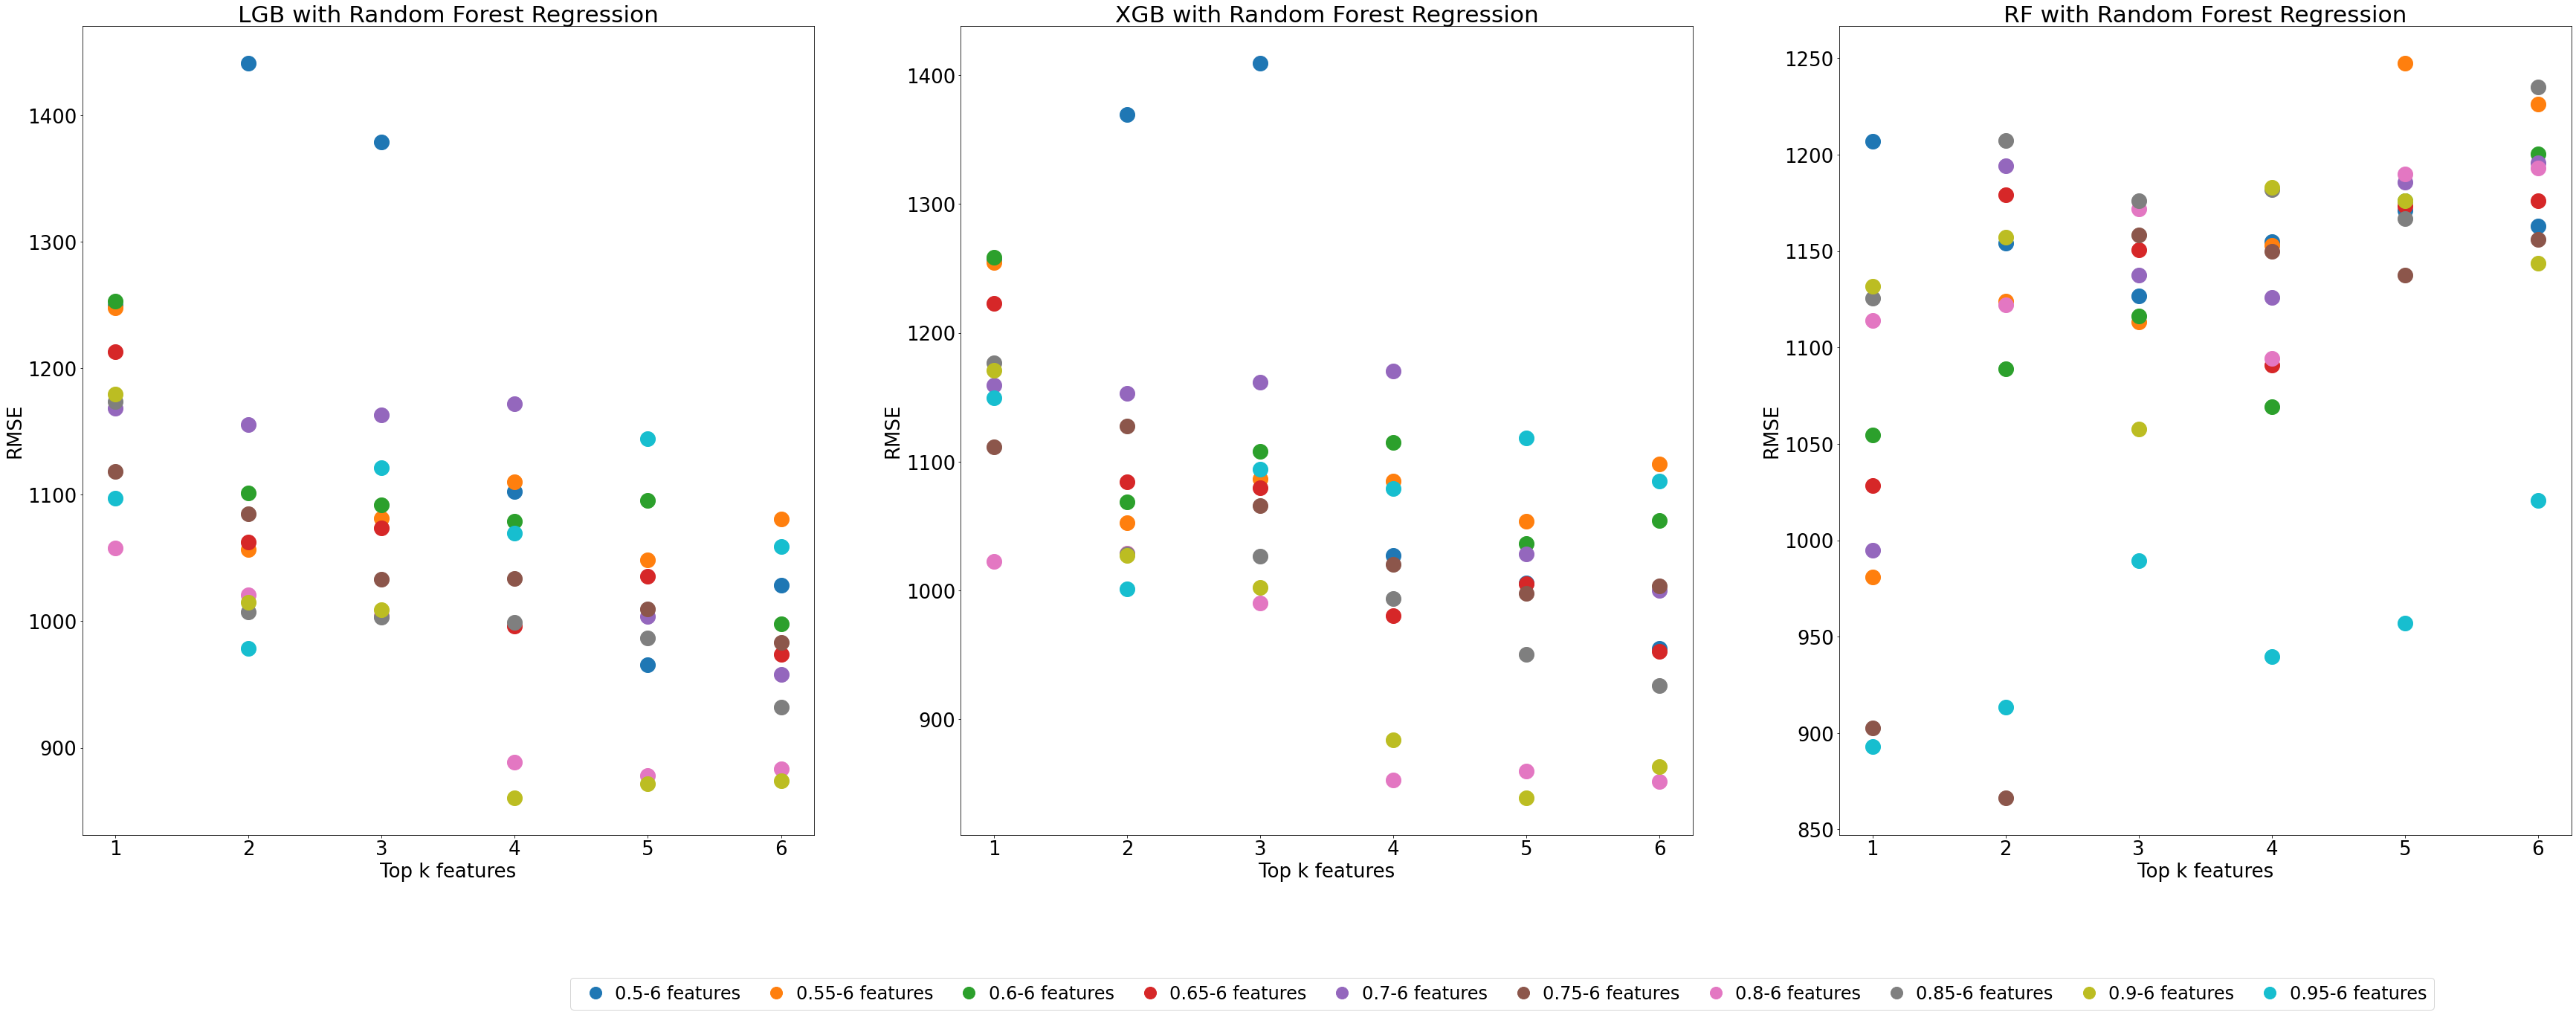

In [90]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with Random Forest Regression")
for k in rfr_lgb_error .keys():
    ax[0].set_xticks(rfr_lgb_error[k].index)
    ax[0].plot(rfr_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(rfr_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with Random Forest Regression")
for k in rfr_xgb_error .keys():
    ax[1].set_xticks(rfr_xgb_error[k].index)
    ax[1].plot(rfr_xgb_error[k]['rmse'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with Random Forest Regression")
for k in rfr_rfr_error.keys():
    ax[2].set_xticks(rfr_rfr_error[k].index)
    ax[2].plot(rfr_rfr_error[k]['rmse'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

In [91]:
def Linear_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    reg_Linear =  LinearRegression()
    reg_Linear.fit(x_train,y_train.reshape(-1,))
    y_Linear_a = reg_Linear.predict(x_test)
    y_Linear_a_inverse =minmax_y_test.inverse_transform(y_Linear_a.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_Linear_a_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_Linear_a_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_Linear_a_inverse,y_test_inverse)
    }
    return error_metrics

In [92]:
y_all = Linear_Regressor(x_train,y_train,x_test_L,y_test_L)

rmse:  2740.0233022473267 mae: 2171.3137320153437


In [33]:
Linear_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  1046.9854061168498 mae: 419.5557888720827


{'rmse': 1046.9854061168498, 'mae': 419.5557888720827}

In [81]:
li_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    li_lgb_error[k] = []
    if type(v)==list:
        li_lgb_error[k].append(Linear_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        li_lgb_error[k] = pd.DataFrame(li_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            li_lgb_error[k].append(Linear_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        li_lgb_error[k] = pd.DataFrame(li_lgb_error[k],index = list(v.keys()))

li_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    li_xgb_error[k] = []
    if type(v)==list:
        li_xgb_error[k].append(Linear_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        li_xgb_error[k] = pd.DataFrame(li_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            li_xgb_error[k].append(Linear_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        li_xgb_error[k] = pd.DataFrame(li_xgb_error[k],index = list(v.keys()))
    
li_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    li_rfr_error[k] = []
    if type(v) == list:
        li_rfr_error[k].append(Linear_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        li_rfr_error[k] = pd.DataFrame(li_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            li_rfr_error[k].append(Linear_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        li_rfr_error[k] = pd.DataFrame(li_rfr_error[k],index = list(v.keys()))

0.5
1 1
rmse:  1128.852842034465 mae: 423.2390071423092
2 5
rmse:  1128.40827806874 mae: 528.541106752367
3 8
rmse:  1129.4986108525777 mae: 543.5702434499369
4 10
rmse:  959.9062087253867 mae: 540.3574558320367
5 13
rmse:  962.9138887849937 mae: 526.4758297676052
6 16
rmse:  964.4149463049968 mae: 521.9221348184749
0.55
1 1
rmse:  1128.852842034465 mae: 423.2390071423092
2 5
rmse:  937.4995374781512 mae: 455.60653419956816
3 6
rmse:  942.0330425194516 mae: 473.75738767111767
4 9
rmse:  922.4061831206704 mae: 464.58268004536905
5 11
rmse:  924.3420887087058 mae: 481.48534812650115
6 13
rmse:  924.3649867855262 mae: 478.8544040524651
0.6
1 1
rmse:  1128.852842034465 mae: 423.2390071423092
2 5
rmse:  937.4995374781512 mae: 455.60653419956816
3 6
rmse:  937.6951990682628 mae: 457.49869313612083
4 9
rmse:  917.4982941423541 mae: 444.94268831185815
5 11
rmse:  921.0063605426203 mae: 468.5363941450862
6 14
rmse:  924.7594607349049 mae: 480.20002803761423
0.65
1 2
rmse:  1128.1219407202432 ma

rmse:  1017.2924923814052 mae: 455.11199621004846
2 6
rmse:  1018.3766522450618 mae: 469.62561770437526
3 8
rmse:  924.437043725738 mae: 359.6882309390126
4 11
rmse:  943.5551969581938 mae: 436.48198197809836
5 14
rmse:  957.6937282242312 mae: 469.6462922287563
6 17
rmse:  961.7597707395014 mae: 488.62111237512215
0.95
1 4
rmse:  909.042941654272 mae: 451.479298838883
2 6
rmse:  906.2756473748497 mae: 434.7242317695745
3 9
rmse:  911.5735438464907 mae: 512.9732395842784
4 11
rmse:  916.060645837369 mae: 486.7628277391549
5 14
rmse:  924.3342558313769 mae: 525.184670891982
6 17
rmse:  981.8118087730296 mae: 681.8376830125939


In [82]:
avg_li_lgb = avg_rmse(li_lgb_error)
avg_li_xgb = avg_rmse(li_xgb_error)
avg_li_rfr = avg_rmse(li_rfr_error)

In [83]:
avg_li_lgb,avg_li_xgb,avg_li_rfr 

(971.654, 971.654, 947.294)

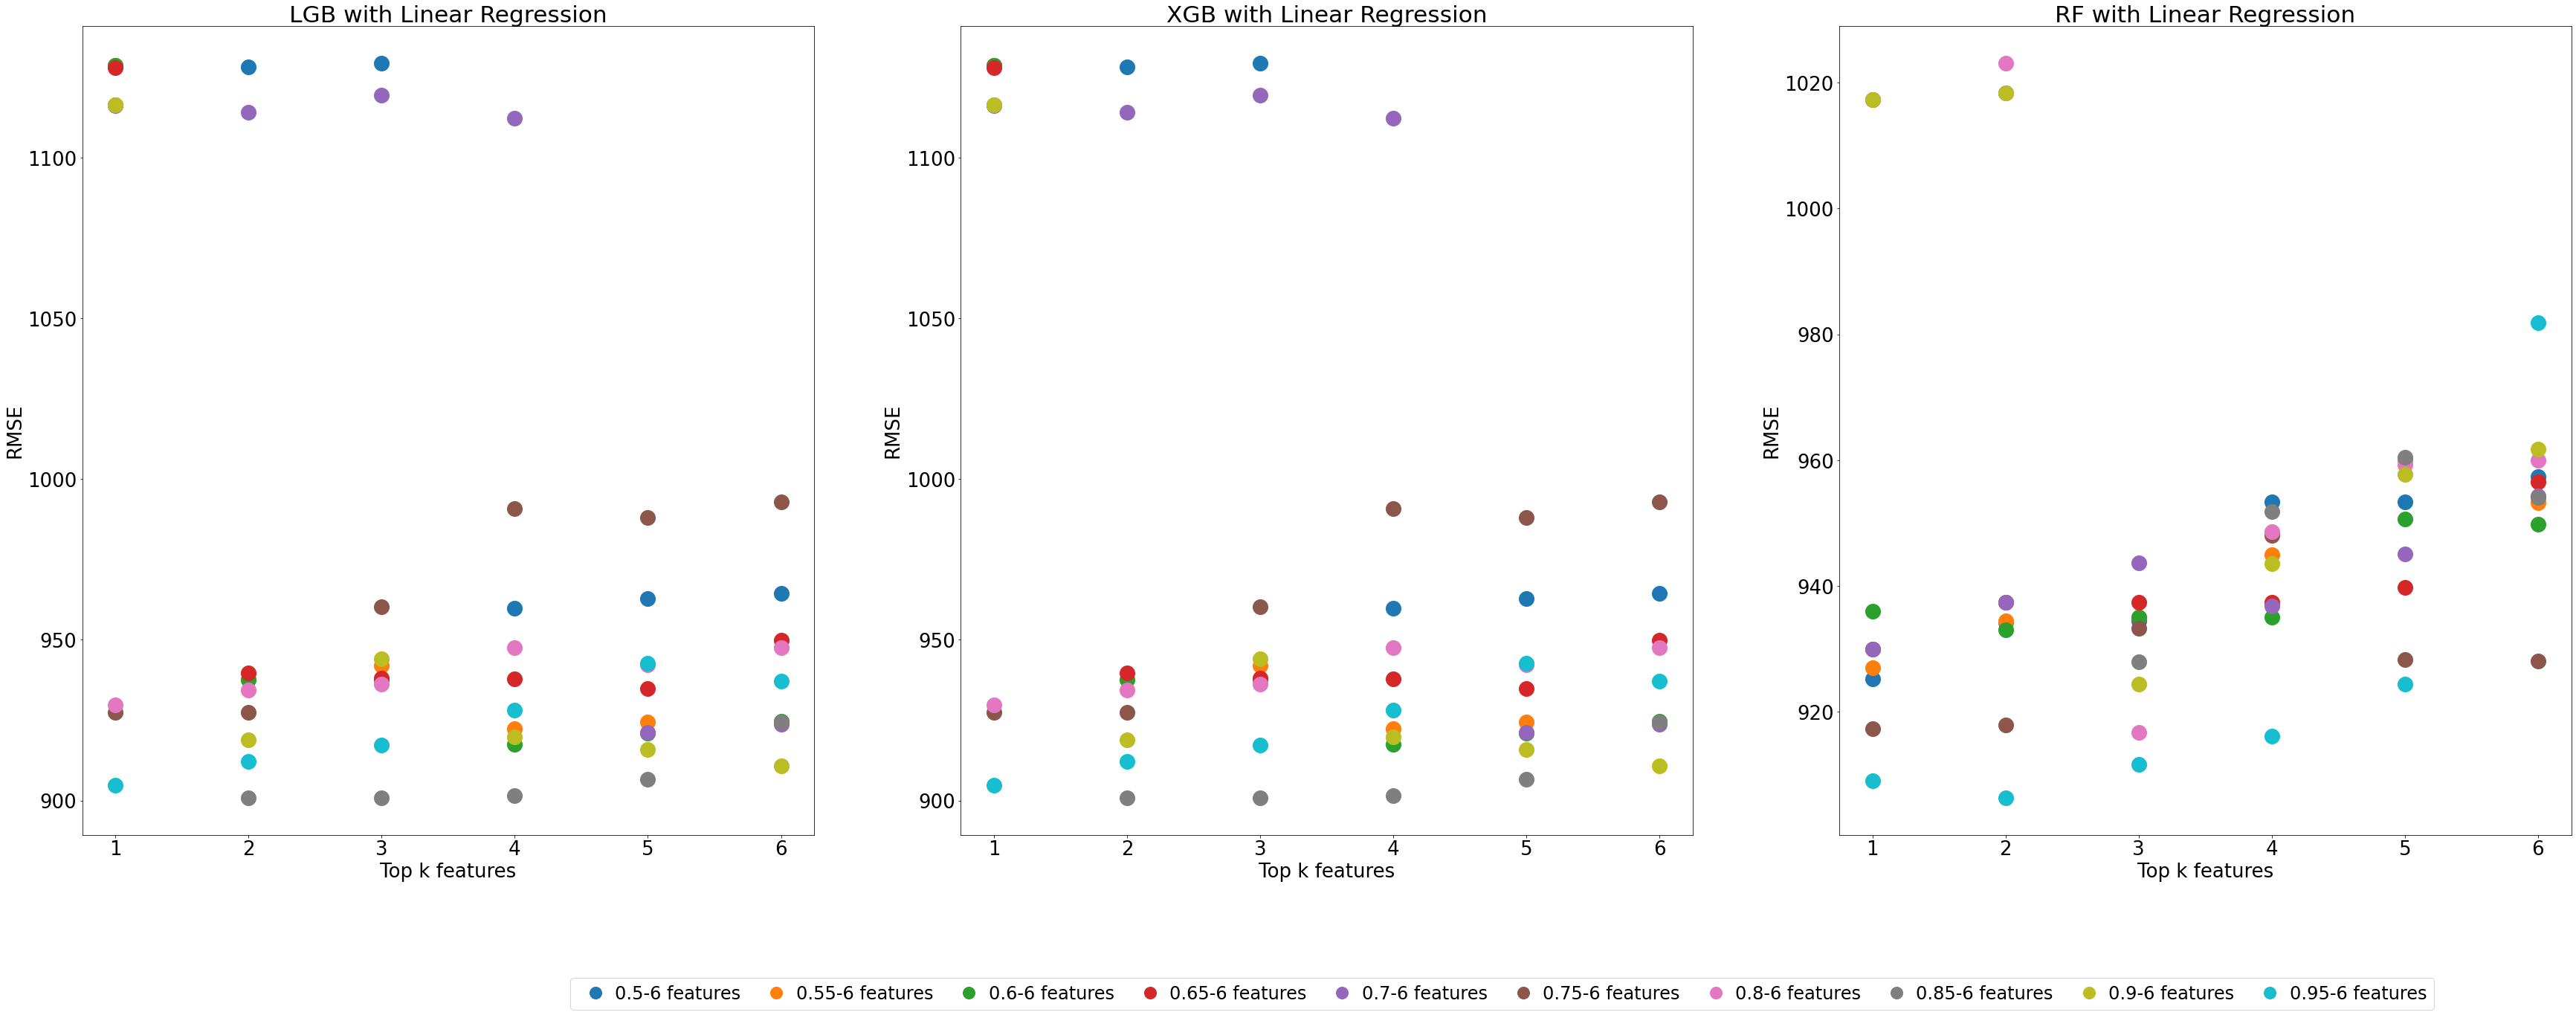

In [93]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with Linear Regression")
for k in li_lgb_error .keys():
    ax[0].set_xticks(li_lgb_error[k].index)
    ax[0].plot(li_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with Linear Regression")
for k in li_xgb_error .keys():
    ax[1].set_xticks(li_xgb_error[k].index)
    ax[1].plot(li_xgb_error[k]['rmse'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with Linear Regression")
for k in li_rfr_error.keys():
    ax[2].set_xticks(li_rfr_error[k].index)
    ax[2].plot(li_rfr_error[k]['rmse'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

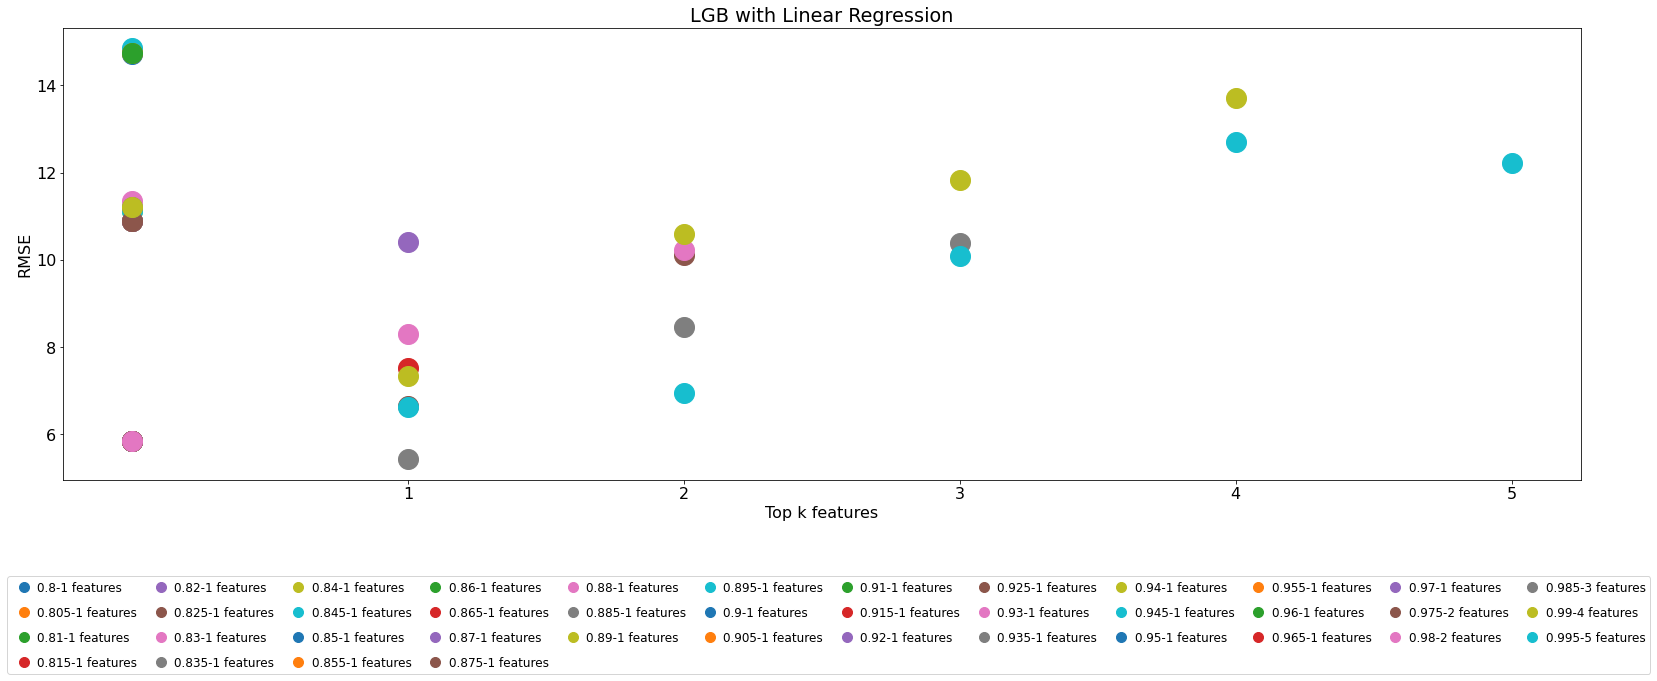

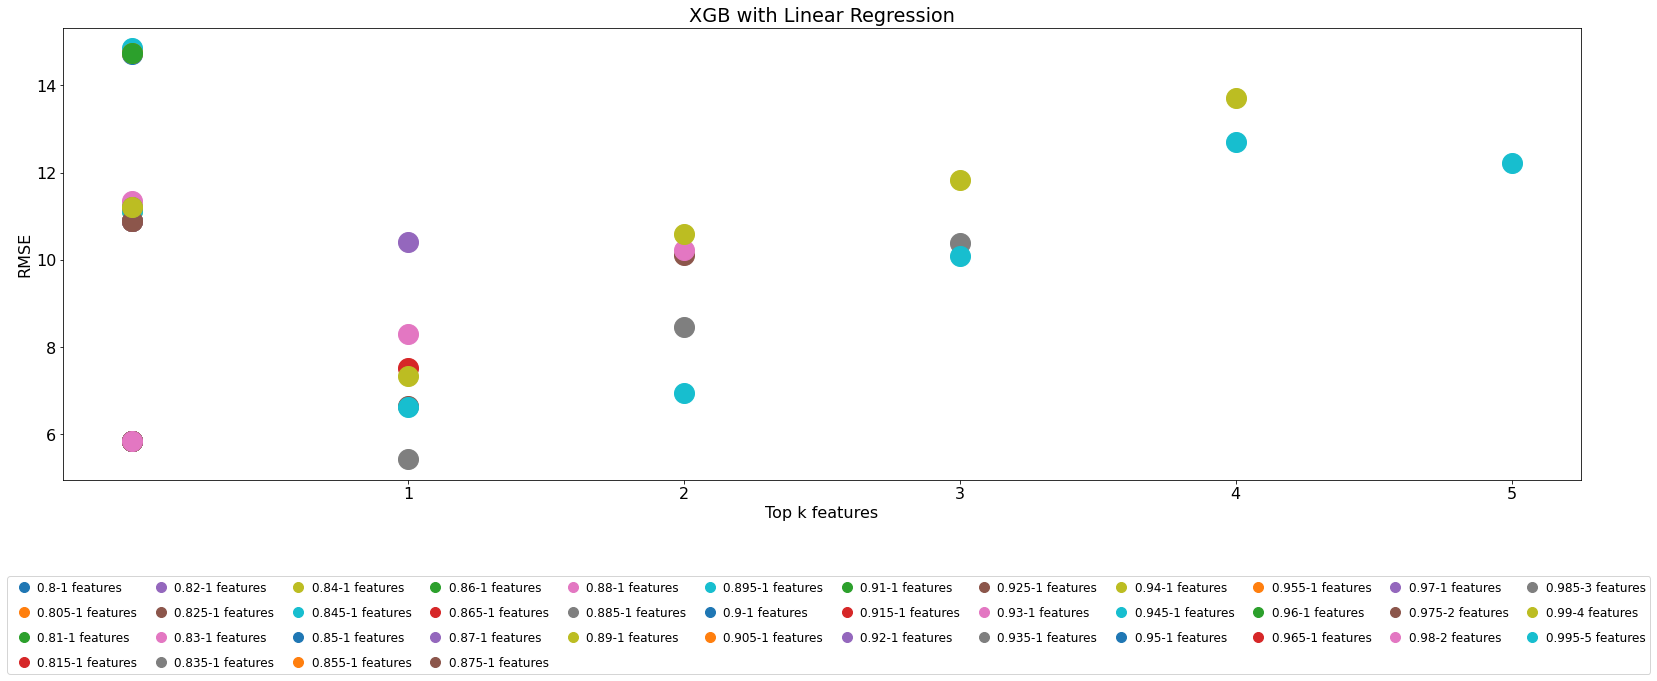

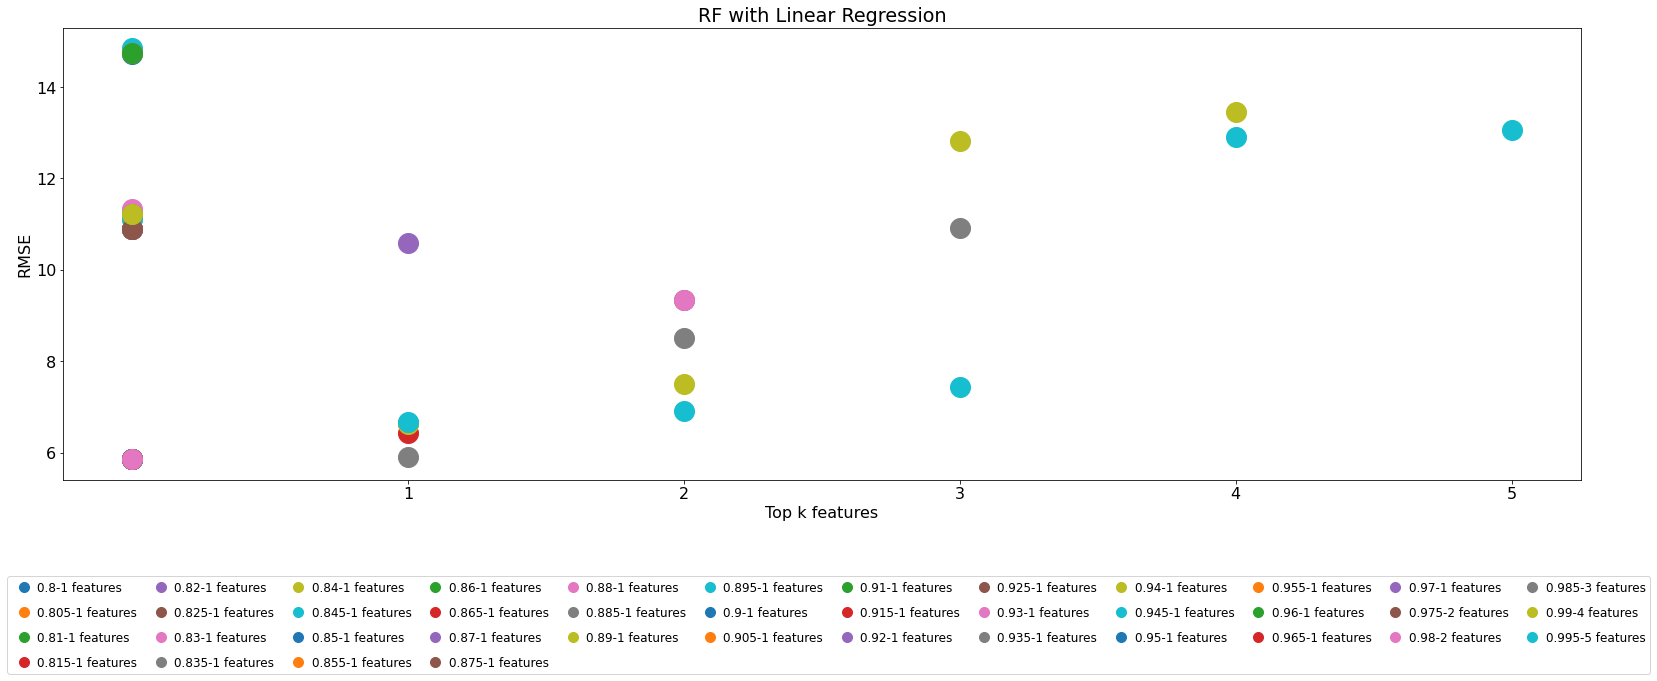

In [359]:
plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'
plt.title("LGB with Linear Regression")
for k in li_lgb_error .keys():
    plt.xticks(li_lgb_error[k].index)
    plt.plot(li_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_lgb_error[k]))+' features',markersize = 20) 
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'

plt.title("XGB with Linear Regression")
for k in li_xgb_error .keys():
    plt.xticks(li_xgb_error[k].index)
    plt.plot(li_xgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_lgb_error[k]))+' features',markersize = 20) 
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
plt.tight_layout()
plt.show()


plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'

plt.title("RF with Linear Regression")
for k in li_rfr_error.keys():
    plt.xticks(li_rfr_error[k].index)
    plt.plot(li_rfr_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_rfr_error[k]))+' features',markersize = 20)  
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
plt.tight_layout()
plt.show()

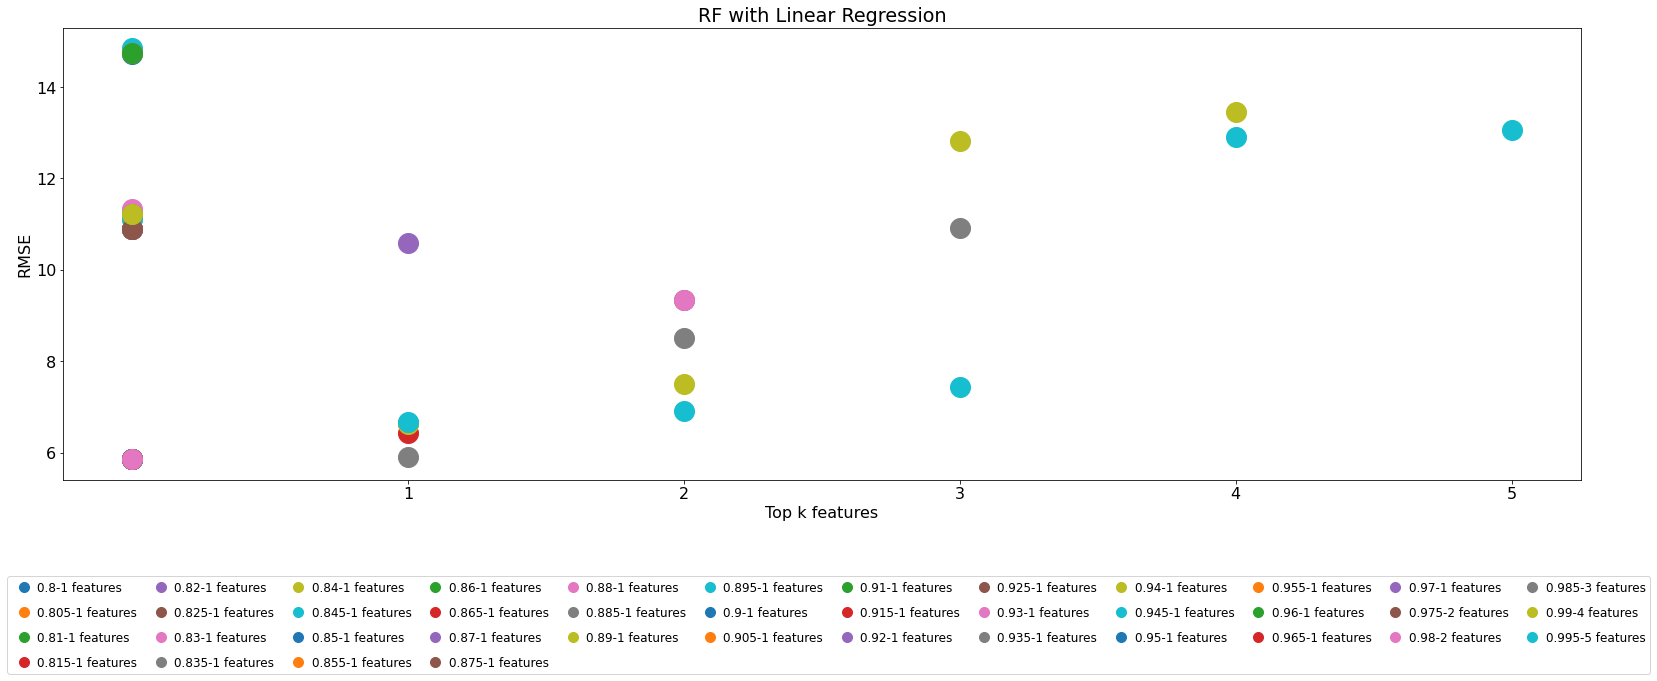

In [358]:
plt.figure(figsize=(25,10))
plt.rcParams['font.size'] = '16'

plt.title("RF with Linear Regression")
for k in li_rfr_error.keys():
    plt.xticks(li_rfr_error[k].index)
    plt.plot(li_rfr_error[k]['rmse'],'o',label = str(k)+"-"+str(len(li_rfr_error[k]))+' features',markersize = 20)  
plt.ylabel("RMSE")
plt.xlabel("Top k features") 
plt.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
plt.tight_layout()

### Support Vector Regression

In [103]:
def SVR_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    parameters = {'kernel':['rbf'], 'gamma':np.logspace(-5, 0, num=6, base=2.0),'C':np.logspace(-5, 5, num=11, base=2.0)}
    svr =  SVR()
    grid_search = GridSearchCV(svr, parameters, cv=10, n_jobs=4, scoring='neg_mean_squared_error')
    grid_search.fit(x_train,y_train.reshape(-1,))
#     print(grid_search.best_params_)
    y_svr = grid_search.predict(x_test)
    
    y_svr_inverse =minmax_y_test.inverse_transform(y_svr.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_svr_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_svr_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_svr_inverse,y_test_inverse)
    }
    
    return error_metrics

In [104]:
SVR_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  1151.0271577656347 mae: 622.0616879886567


{'rmse': 1151.0271577656347, 'mae': 622.0616879886567}

In [105]:
SVR_Regressor(x_train,y_train,x_test_L,y_test_L)

rmse:  1097.6449073690096 mae: 603.7516015515902


{'rmse': 1097.6449073690096, 'mae': 603.7516015515902}

In [106]:
svr_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    svr_lgb_error[k] = []
    if type(v)==list:
        svr_lgb_error[k].append(SVR_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        svr_lgb_error[k] = pd.DataFrame(svr_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            svr_lgb_error[k].append(SVR_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        svr_lgb_error[k] = pd.DataFrame(svr_lgb_error[k],index = list(v.keys()))

svr_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    svr_xgb_error[k] = []
    if type(v)==list:
        svr_xgb_error[k].append(SVR_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        svr_xgb_error[k] = pd.DataFrame(svr_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            svr_xgb_error[k].append(SVR_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        svr_xgb_error[k] = pd.DataFrame(svr_xgb_error[k],index = list(v.keys()))
    
svr_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    svr_rfr_error[k] = []
    if type(v) == list:
        svr_rfr_error[k].append(SVR_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        svr_rfr_error[k] = pd.DataFrame(svr_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            svr_rfr_error[k].append(SVR_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        svr_rfr_error[k] = pd.DataFrame(svr_rfr_error[k],index = list(v.keys()))

0.5
1 1
rmse:  1112.6973950158833 mae: 560.8935221792776
2 5
rmse:  1122.8985532215868 mae: 615.826273423681
3 8
rmse:  1197.3902660966128 mae: 808.2984521022069
4 10
rmse:  1055.556254551312 mae: 697.4022722226694
5 13
rmse:  1038.600412543484 mae: 641.9825578381526
6 16
rmse:  1122.0056985455167 mae: 687.424863528019
0.55
1 1
rmse:  1112.6973950158833 mae: 560.8935221792776
2 5
rmse:  1080.290361363279 mae: 606.9826739697621
3 6
rmse:  1330.0487552960503 mae: 830.1567037448623
4 9
rmse:  1114.272881617794 mae: 670.2600033703361
5 11
rmse:  1069.7607817114717 mae: 646.1211054454258
6 13
rmse:  1074.278518005718 mae: 634.9247837681071
0.6
1 1
rmse:  1112.6973950158833 mae: 560.8935221792776
2 5
rmse:  1080.290361363279 mae: 606.9826739697621
3 6
rmse:  1080.7443607644839 mae: 629.9088634821378
4 9
rmse:  1063.2409766785997 mae: 586.2716706457851
5 11
rmse:  1060.9054471037923 mae: 623.6643015774845
6 14
rmse:  1070.4213561481738 mae: 632.2780300252971
0.65
1 2
rmse:  1116.3391841251334

rmse:  1032.6604073231804 mae: 549.4143292718
5 11
rmse:  1091.5150869769145 mae: 595.4039291785416
6 13
rmse:  1021.9819121722838 mae: 568.4662512404254
0.8
1 2
rmse:  1101.236370564866 mae: 590.2877273267125
2 6
rmse:  1072.2797727141576 mae: 564.8560092027552
3 8
rmse:  1052.3232510825198 mae: 548.7244903656099
4 11
rmse:  1068.8305422454127 mae: 550.0217246885978
5 14
rmse:  1071.9072103223693 mae: 559.5506282496477
6 17
rmse:  1100.6750228409867 mae: 588.3156675632528
0.85
1 2
rmse:  1101.236370564866 mae: 590.2877273267125
2 5
rmse:  1102.7260608533536 mae: 587.5596432310032
3 10
rmse:  1086.192418434662 mae: 591.1020653841971
4 11
rmse:  1075.3935816862179 mae: 581.9156070859551
5 13
rmse:  1080.847074271875 mae: 575.6509717618657
6 14
rmse:  1084.825408425989 mae: 557.5781036819164
0.9
1 2
rmse:  1101.236370564866 mae: 590.2877273267125
2 6
rmse:  1097.5887817645605 mae: 577.6136530199
3 8
rmse:  1095.3168477710665 mae: 587.741105156487
4 11
rmse:  1056.2096817013771 mae: 555.2

In [108]:
avg_svr_lgb = avg_rmse(svr_lgb_error)
avg_svr_xgb = avg_rmse(svr_xgb_error)
avg_svr_rfr = avg_rmse(svr_rfr_error)

avg_svr_lgb,avg_svr_xgb,avg_svr_rfr 

(61.599, 61.599, 59.088)

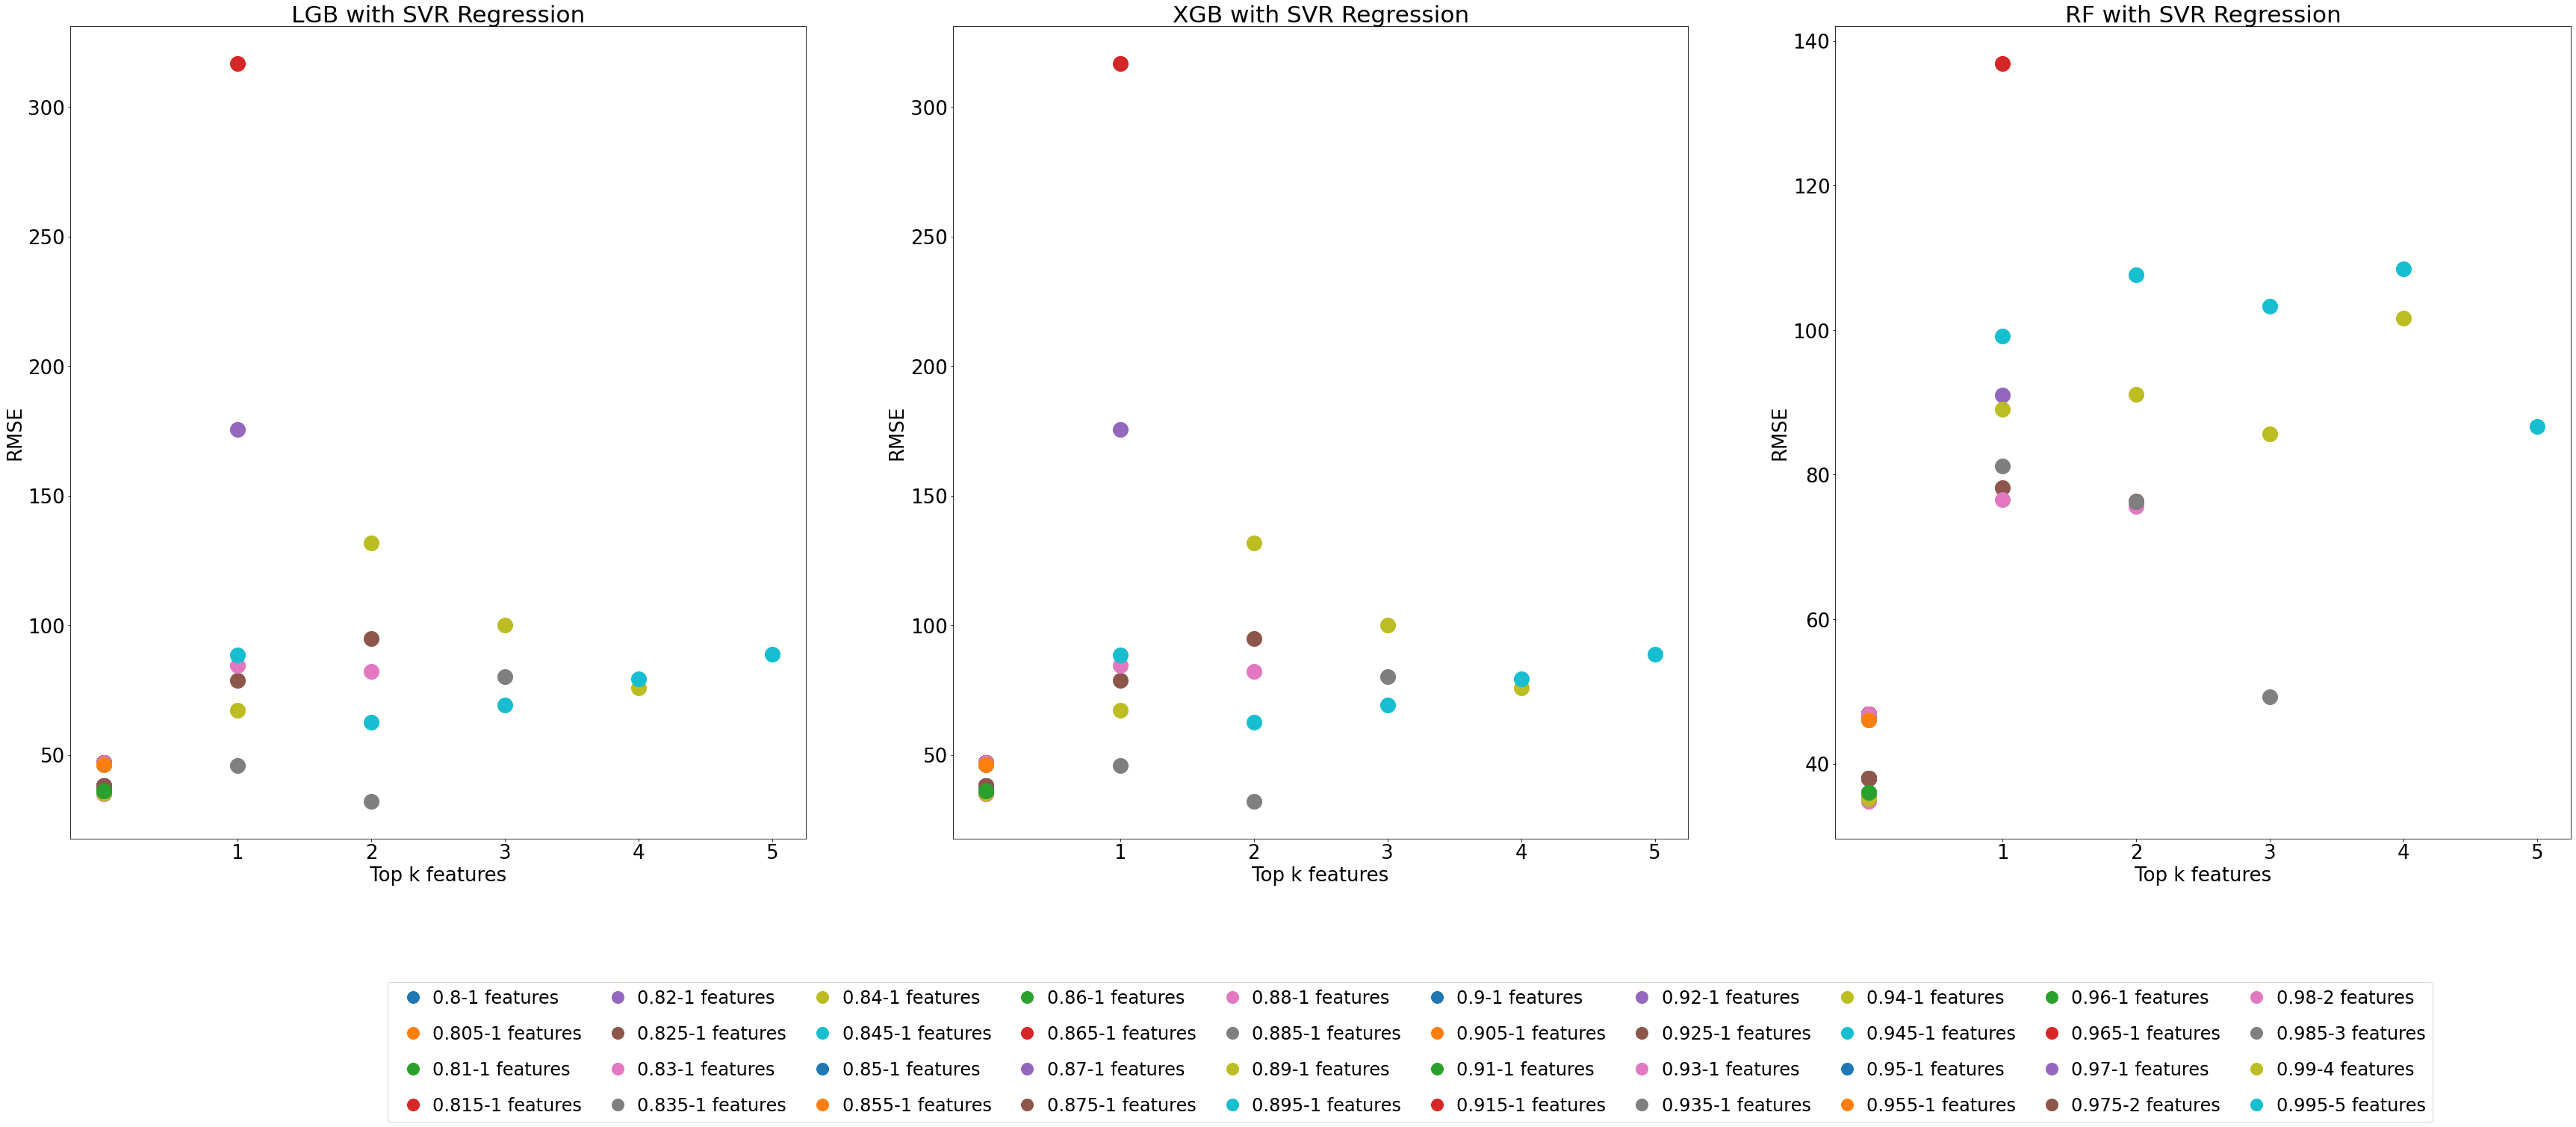

In [459]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with SVR Regression")
for k in svr_lgb_error .keys():
    ax[0].set_xticks(svr_lgb_error[k].index)
    ax[0].plot(svr_lgb_error[k]['rmse'],'o',label = str(k)+"-"+str(len(svr_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with SVR Regression")
for k in svr_xgb_error .keys():
    ax[1].set_xticks(svr_xgb_error[k].index)
    ax[1].plot(svr_xgb_error[k]['rmse'],'o',markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with SVR Regression")
for k in svr_rfr_error.keys():
    ax[2].set_xticks(svr_rfr_error[k].index)
    ax[2].plot(svr_rfr_error[k]['rmse'],'o',markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

In [37]:
def xgb_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    
    xgb = XGBRegressor(n_jobs=-1, n_estimators=100, max_depth=4, random_state=99)
    xgb.fit(x_train,y_train.reshape(-1,))
    y_xgb = xgb.predict(x_test)
    y_xgb_inverse =minmax_y_test.inverse_transform(y_xgb.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_xgb_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_xgb_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_xgb_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_xgb_inverse,y_test_inverse)
    }
    
    return error_metrics

In [38]:
xgb_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  1078.2246466146587 mae: 538.3404466299191


{'rmse': 1078.2246466146587, 'mae': 538.3404466299191}

In [74]:
xgb_Regressor(x_train,y_train,x_test_L,y_test_L)

rmse:  856.4309970057569 mae: 409.46250999005923


{'rmse': 856.4309970057569, 'mae': 409.46250999005923}

In [94]:
xgb_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    xgb_lgb_error[k] = []
    if type(v)==list:
        xgb_lgb_error[k].append(xgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        xgb_lgb_error[k] = pd.DataFrame(xgb_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            xgb_lgb_error[k].append(xgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        xgb_lgb_error[k] = pd.DataFrame(xgb_lgb_error[k],index = list(v.keys()))

xgb_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    xgb_xgb_error[k] = []
    if type(v)==list:
        xgb_xgb_error[k].append(xgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        xgb_xgb_error[k] = pd.DataFrame(xgb_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            xgb_xgb_error[k].append(xgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        xgb_xgb_error[k] = pd.DataFrame(xgb_xgb_error[k],index = list(v.keys()))
    
xgb_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    xgb_rfr_error[k] = []
    if type(v) == list:
        xgb_rfr_error[k].append(xgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        xgb_rfr_error[k] = pd.DataFrame(xgb_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            xgb_rfr_error[k].append(xgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        xgb_rfr_error[k] = pd.DataFrame(xgb_rfr_error[k],index = list(v.keys()))

0.5
1 1
rmse:  1287.4107324250815 mae: 493.25160264264485
2 5
rmse:  1662.998165781862 mae: 910.9567055723447
3 8
rmse:  1656.6803659488144 mae: 914.4129350379711
4 10
rmse:  1232.869024485714 mae: 671.3385951349575
5 13
rmse:  1191.4193907133251 mae: 652.9521182084313
6 16
rmse:  1260.2527601846239 mae: 664.2973378635951
0.55
1 1
rmse:  1287.4107324250815 mae: 493.25160264264485
2 5
rmse:  1218.4320536274818 mae: 537.2693096757685
3 6
rmse:  1170.5773079291794 mae: 548.1351281906126
4 9
rmse:  1333.8812209078267 mae: 683.3678166356235
5 11
rmse:  1345.3564630251656 mae: 725.8826805305135
6 13
rmse:  1317.966377845497 mae: 692.1850244610835
0.6
1 1
rmse:  1287.4107324250815 mae: 493.25160264264485
2 5
rmse:  1218.4320536274818 mae: 537.2693096757685
3 6
rmse:  1302.9413443291064 mae: 672.9206204865227
4 9
rmse:  1326.1993062379963 mae: 709.1961637371911
5 11
rmse:  1302.7116368802199 mae: 634.2637646963193
6 14
rmse:  1291.1302417560246 mae: 671.7542478155896
0.65
1 2
rmse:  1293.51961

rmse:  1252.0715907709648 mae: 531.1115143650625
5 11
rmse:  1228.3045340442684 mae: 534.5225289736776
6 13
rmse:  1347.1781824844836 mae: 625.3129880637749
0.8
1 2
rmse:  1209.5796389976376 mae: 504.6726853973925
2 6
rmse:  1169.1355726629174 mae: 486.89430069515515
3 8
rmse:  1105.5288982355494 mae: 514.3506128581989
4 11
rmse:  1201.5912253685462 mae: 577.6175531250566
5 14
rmse:  1339.2795742794606 mae: 617.7700946667854
6 17
rmse:  1344.914815625362 mae: 688.5200938186197
0.85
1 2
rmse:  1209.5796389976376 mae: 504.6726853973925
2 5
rmse:  1192.984224919626 mae: 540.447098642794
3 10
rmse:  1229.3756665896553 mae: 539.0007834681419
4 11
rmse:  1280.8333171580907 mae: 630.3726384216907
5 13
rmse:  1328.7954815666612 mae: 656.0884858316896
6 14
rmse:  1242.1895354306055 mae: 583.4373952067929
0.9
1 2
rmse:  1209.5796389976376 mae: 504.6726853973925
2 6
rmse:  1179.9721054129664 mae: 502.4528462535336
3 8
rmse:  1161.5878773784814 mae: 513.3142901936434
4 11
rmse:  1352.1043356711557

In [95]:
avg_xgb_lgb = avg_rmse(xgb_lgb_error)
avg_xgb_xgb = avg_rmse(xgb_xgb_error)
avg_xgb_rfr = avg_rmse(xgb_rfr_error)

avg_xgb_lgb,avg_xgb_xgb,avg_xgb_rfr 

(1186.93, 1186.93, 1257.784)

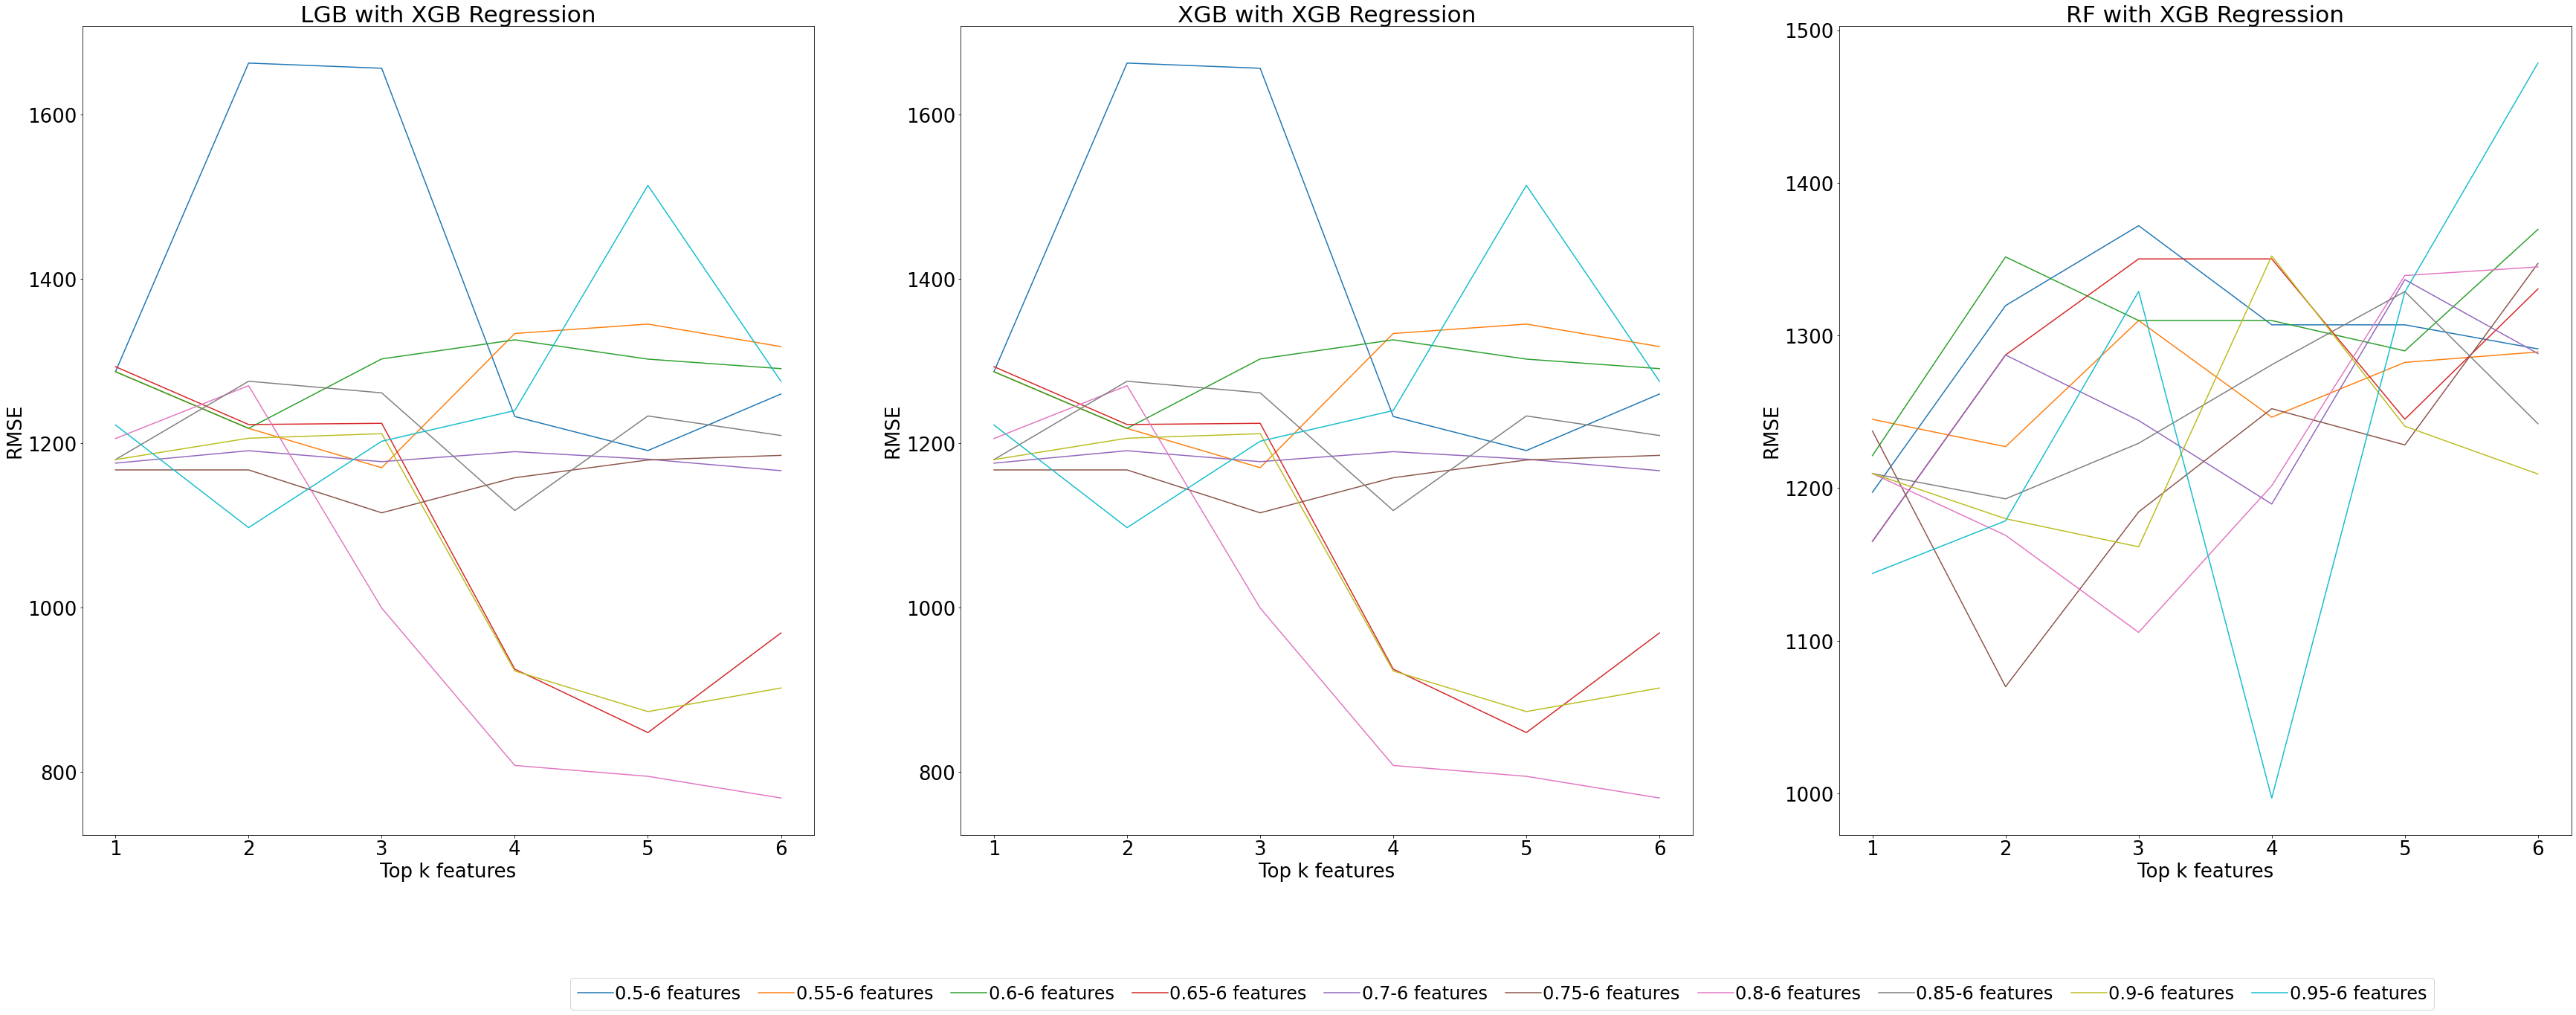

In [97]:
fig,ax = plt.subplots(1,3,figsize=(60,20))

plt.rcParams['font.size'] = '26'

ax[0].set_title("LGB with XGB Regression")
for k in xgb_lgb_error .keys():
    ax[0].set_xticks(xgb_lgb_error[k].index)
    ax[0].plot(xgb_lgb_error[k]['rmse'],label = str(k)+"-"+str(len(xgb_lgb_error[k]))+' features',markersize = 20) 
ax[0].set_ylabel("RMSE")
ax[0].set_xlabel("Top k features") 
# ax[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
ax[0].set_visible(True)


ax[1].set_title("XGB with XGB Regression")
for k in xgb_xgb_error .keys():
    ax[1].set_xticks(xgb_xgb_error[k].index)
    ax[1].plot(xgb_xgb_error[k]['rmse'],markersize = 20) 
ax[1].set_ylabel("RMSE")
ax[1].set_xlabel("Top k features") 

ax[2].set_title("RF with XGB Regression")
for k in xgb_rfr_error.keys():
    ax[2].set_xticks(xgb_rfr_error[k].index)
    ax[2].plot(xgb_rfr_error[k]['rmse'],markersize = 20)  
ax[2].set_ylabel("RMSE")
ax[2].set_xlabel("Top k features") 

fig.legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.86, 0),ncol=10,handletextpad=0.1,fontsize=24)

In [98]:
def lgb_Regressor(X_train,Y_train,X_test,Y_test):
    minmax_x_train = MinMaxScaler(feature_range = (0,1))
    minmax_y_train = MinMaxScaler(feature_range = (0,1))
    minmax_x_test = MinMaxScaler(feature_range = (0,1))
    minmax_y_test = MinMaxScaler(feature_range = (0,1))
    
    x_train = minmax_x_train.fit_transform(X_train)
    y_train = minmax_y_train.fit_transform(Y_train.values.reshape(-1,1))
    x_test = minmax_x_test.fit_transform(X_test)
    y_test= minmax_y_test.fit_transform(Y_test.values.reshape((-1,1)))
    y_test_inverse = minmax_y_test.inverse_transform( y_test.reshape(-1,1) )
    
    gbm = lgb.LGBMRegressor()
    gbm.fit(x_train, y_train)
    y_gbm = gbm.predict(x_test)
    y_gbm_inverse =minmax_y_test.inverse_transform(y_gbm.reshape((-1,1)))
    
    print(
        "rmse: ",sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
         "mae:",mean_absolute_error(y_gbm_inverse,y_test_inverse)
    )
    
    
    error_metrics = {
        "rmse":sqrt(mean_squared_error(y_gbm_inverse,y_test_inverse)),
        "mae":mean_absolute_error(y_gbm_inverse,y_test_inverse)
    }
    
    
    return error_metrics

In [100]:
lgb_Regressor(x_train_no,y_train_no,x_test_no,y_test_no)

rmse:  1081.6984738875587 mae: 492.93537528867614


{'rmse': 1081.6984738875587, 'mae': 492.93537528867614}

In [101]:
lgb_Regressor(x_train,y_train,x_test_L,y_test_L)

rmse:  1111.8211945352714 mae: 628.1453391229658


{'rmse': 1111.8211945352714, 'mae': 628.1453391229658}

In [99]:
lgb_lgb_error = {}
for k,v in real_lgb.items():
    print(k)
    lgb_lgb_error[k] = []
    if type(v)==list:
        lgb_lgb_error[k].append(lgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        lgb_lgb_error[k] = pd.DataFrame(lgb_lgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            lgb_lgb_error[k].append(lgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        lgb_lgb_error[k] = pd.DataFrame(lgb_lgb_error[k],index = list(v.keys()))

lgb_xgb_error = {}
for k,v in real_xgb.items():
    print(k)
    lgb_xgb_error[k] = []
    if type(v)==list:
        lgb_xgb_error[k].append(lgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        lgb_xgb_error[k] = pd.DataFrame(lgb_xgb_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            lgb_xgb_error[k].append(lgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        lgb_xgb_error[k] = pd.DataFrame(lgb_xgb_error[k],index = list(v.keys()))
    
lgb_rfr_error = {}
for k,v in real_rfr.items():
    print(k)
    lgb_rfr_error[k] = []
    if type(v) == list:
        lgb_rfr_error[k].append(lgb_Regressor(x_train[v],y_train,x_test_L[v],y_test_L))
        lgb_rfr_error[k] = pd.DataFrame(lgb_rfr_error[k])
    else:
        for kk,vv in v.items():
            print(kk,len(vv))
            lgb_rfr_error[k].append(lgb_Regressor(x_train[vv],y_train,x_test_L[vv],y_test_L))
        lgb_rfr_error[k] = pd.DataFrame(lgb_rfr_error[k],index = list(v.keys()))

0.5
1 1
rmse:  1199.3698198905797 mae: 544.9472503988802
2 5
rmse:  1266.693320407548 mae: 688.759476090281
3 8
rmse:  1342.060709249132 mae: 828.8675966623643
4 10
rmse:  1284.4610379038545 mae: 863.6955209402115
5 13
rmse:  1261.597058775002 mae: 804.7518144903959
6 16
rmse:  1263.7353607103132 mae: 807.510475085575
0.55
1 1
rmse:  1199.3698198905797 mae: 544.9472503988802
2 5
rmse:  1162.1989261304134 mae: 645.7674963678847
3 6
rmse:  1257.4629431359433 mae: 885.7041072314986
4 9
rmse:  1332.4612491430103 mae: 861.9982345541168
5 11
rmse:  1308.963414937078 mae: 873.596322294745
6 13
rmse:  1295.7625942287534 mae: 821.692618000366
0.6
1 1
rmse:  1199.3698198905797 mae: 544.9472503988802
2 5
rmse:  1162.1989261304134 mae: 645.7674963678847
3 6
rmse:  1237.416251790162 mae: 726.6530326867249
4 9
rmse:  1267.3057421187573 mae: 776.0272395934361
5 11
rmse:  1255.2668748024532 mae: 789.4110362882917
6 14
rmse:  1267.7597699884948 mae: 820.9816910270738
0.65
1 2
rmse:  1259.3434788741558 

3 8
rmse:  1001.68362573312 mae: 501.57509487703226
4 11
rmse:  1104.8186578938232 mae: 601.2993953189459
5 14
rmse:  1124.6771443227303 mae: 589.8783800551452
6 17
rmse:  1145.446153140698 mae: 599.02669682103
0.85
1 2
rmse:  1146.167213855917 mae: 512.6089512314825
2 5
rmse:  1108.6237805640644 mae: 468.50760365243036
3 10
rmse:  1059.2272463819936 mae: 510.1378110436831
4 11
rmse:  1100.2768715272132 mae: 566.7368893938908
5 13
rmse:  1128.5826892340892 mae: 633.8705427285755
6 14
rmse:  1154.5199291976057 mae: 573.912716434198
0.9
1 2
rmse:  1146.167213855917 mae: 512.6089512314825
2 6
rmse:  1113.32234195582 mae: 495.635703345962
3 8
rmse:  991.111675334376 mae: 490.74990818441603
4 11
rmse:  1030.5805784146428 mae: 580.108923275953
5 14
rmse:  1133.44695236701 mae: 614.1546732965775
6 17
rmse:  1169.4841915489849 mae: 671.6314249522128
0.95
1 4
rmse:  964.4295369889992 mae: 498.761810370939
2 6
rmse:  965.757463436695 mae: 538.140058816138
3 9
rmse:  989.2118832189356 mae: 587.19

In [102]:
avg_lgb_lgb = avg_rmse(lgb_lgb_error)
avg_lgb_xgb = avg_rmse(lgb_xgb_error)
avg_lgb_rfr = avg_rmse(lgb_rfr_error)

avg_lgb_lgb,avg_lgb_xgb,avg_lgb_rfr 

(1172.066, 1172.066, 1129.295)

In [1]:
plt.rcParams['font.size'] = '40'
fig,axes = plt.subplots(5,3,figsize=(100,60),dpi = 600,constrained_layout=True)

axes[0,0].set_title("LGB with Random Forest Regression")
for k in rfr_lgb_error .keys():
    axes[0,0].set_xticks(rfr_lgb_error[k].index)
    axes[0,0].plot(rfr_lgb_error[k]['rmse:'],'o',markersize = 30) 
axes[0,0].set_visible(True)

axes[0,1].set_title("XGB with Random Forest Regression")
for k in rfr_xgb_error .keys():
    axes[0,1].set_xticks(rfr_xgb_error[k].index)
    axes[0,1].plot(rfr_xgb_error[k]['rmse:'],'o',markersize = 30) 

axes[0,2].set_title("RF with Random Forest Regression")
for k in rfr_rfr_error.keys():
    axes[0,2].set_xticks(rfr_rfr_error[k].index)
    axes[0,2].plot(rfr_rfr_error[k]['rmse:'],'o',markersize = 30)  


axes[1,0].set_title("LGB with Linear Regression")
for k in li_lgb_error .keys():
    axes[1,0].set_xticks(li_lgb_error[k].index)
    axes[1,0].plot(li_lgb_error[k]['rmse'],'o',markersize=30) 

# axes[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
axes[1,0].set_visible(True)


axes[1,1].set_title("XGB with Linear Regression")
for k in li_xgb_error .keys():
    axes[1,1].set_xticks(li_xgb_error[k].index)
    axes[1,1].plot(li_xgb_error[k]['rmse'],'o',markersize = 30) 


axes[1,2].set_title("RF with Linear Regression")
for k in li_rfr_error.keys():
    axes[1,2].set_xticks(li_rfr_error[k].index)
    axes[1,2].plot(li_rfr_error[k]['rmse'],'o',markersize = 30)  
axes[1,2].set_ylabel("RMSE")
axes[1,2].set_xlabel("Top k features") 


axes[2,0].set_title("LGB with SVR Regression")
for k in svr_lgb_error .keys():
    axes[2,0].set_xticks(svr_lgb_error[k].index)
    axes[2,0].plot(svr_lgb_error[k]['rmse'],'o',markersize = 30) 

axes[2,0].set_visible(True)


axes[2,1].set_title("XGB with SVR Regression")
for k in svr_xgb_error .keys():
    axes[2,1].set_xticks(svr_xgb_error[k].index)
    axes[2,1].plot(svr_xgb_error[k]['rmse'],'o',markersize = 30) 
 

axes[2,2].set_title("RF with SVR Regression")
for k in svr_rfr_error.keys():
    axes[2,2].set_xticks(svr_rfr_error[k].index)
    axes[2,2].plot(svr_rfr_error[k]['rmse'],'o',markersize = 30)  


axes[3,0].set_title("LGB with XGB Regression")
for k in xgb_lgb_error .keys():
    axes[3,0].set_xticks(xgb_lgb_error[k].index)
    axes[3,0].plot(xgb_lgb_error[k]['rmse'],'o',markersize = 30) 


axes[3,0].set_visible(True)


axes[4,1].set_title("XGB with XGB Regression")
for k in xgb_xgb_error .keys():
    axes[3,1].set_xticks(xgb_xgb_error[k].index)
    axes[3,1].plot(xgb_xgb_error[k]['rmse'],'o',markersize = 30) 


axes[3,2].set_title("RF with XGB Regression")
for k in xgb_rfr_error.keys():
    axes[3,2].set_xticks(xgb_rfr_error[k].index)
    axes[3,2].plot(xgb_rfr_error[k]['rmse'],'o',markersize = 30)  


axes[4,0].set_title("LGB with LGB Regression")
for k in lgb_lgb_error .keys():
    axes[4,0].set_xticks(lgb_lgb_error[k].index)
    axes[4,0].plot(lgb_lgb_error[k]['rmse'],'o',markersize = 30) 

# axes[0].legend(scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.5,bbox_to_anchor=(1.05, -0.2),ncol=12,handletextpad=0.1,fontsize=12)
axes[4,0].set_visible(True)


axes[4,1].set_title("XGB with LGB Regression")
for k in lgb_xgb_error.keys():
    axes[4,1].set_xticks(lgb_xgb_error[k].index)
    axes[4,1].plot(lgb_xgb_error[k]['rmse'],'o',markersize = 30) 
 
axes[4,2].set_title("RF with LGB Regression")
for k in lgb_rfr_error.keys():
    axes[4,2].set_xticks(lgb_rfr_error[k].index)
    axes[4,2].plot(lgb_rfr_error[k]['rmse'],'o',markersize = 30)  

fig.tight_layout()
fig.text(0.5, -0.02, 'Top k features', ha='center',fontsize=50)
fig.text(-0.02, 0.5, 'RMSE', va='center', rotation='vertical',fontsize=50)
fig.legend(list(real_lgb.keys()),scatterpoints=1, labelspacing=1,columnspacing=1,markerscale=0.8,bbox_to_anchor=(0.8,-0.03),ncol=10,handletextpad=4,fontsize=50)
plt.savefig('rmse_diamond.png')
plt.show()

NameError: name 'plt' is not defined